Current system is Ubuntu
9
[array([ 8,  9, 19, 20]), array([ 0,  1, 10, 11]), array([ 6,  7, 16, 17, 18, 27, 28]), array([ 2,  3, 12, 13, 14, 23, 24]), array([29, 30, 40, 41, 50, 51]), array([21, 22, 31, 32, 42, 43]), array([38, 39, 48, 49]), array([33, 34, 44, 45]), array([ 4,  5, 15, 25, 26, 35, 36, 37, 46, 47])]
HbO: (64, 1250, 9)


/tmp/ipykernel_3901483/1826037779.py:209: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 3, figsize=(15, 15))


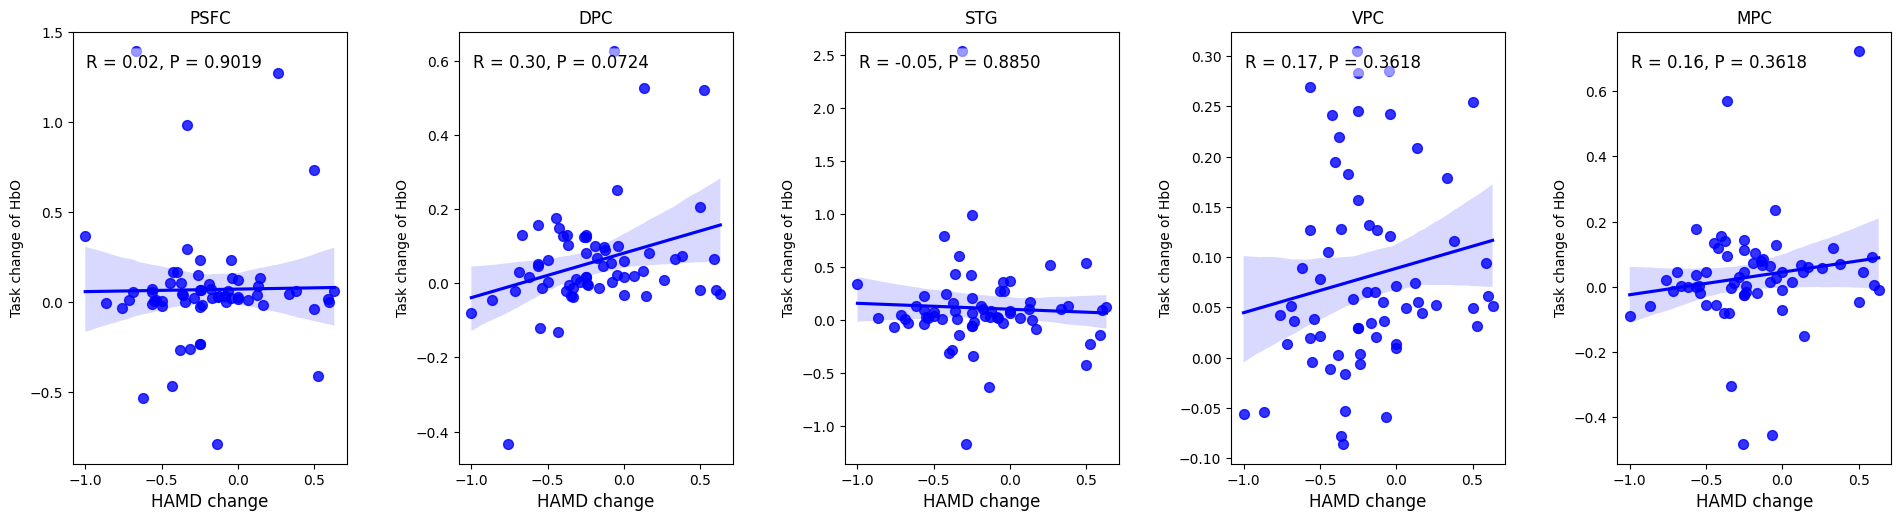

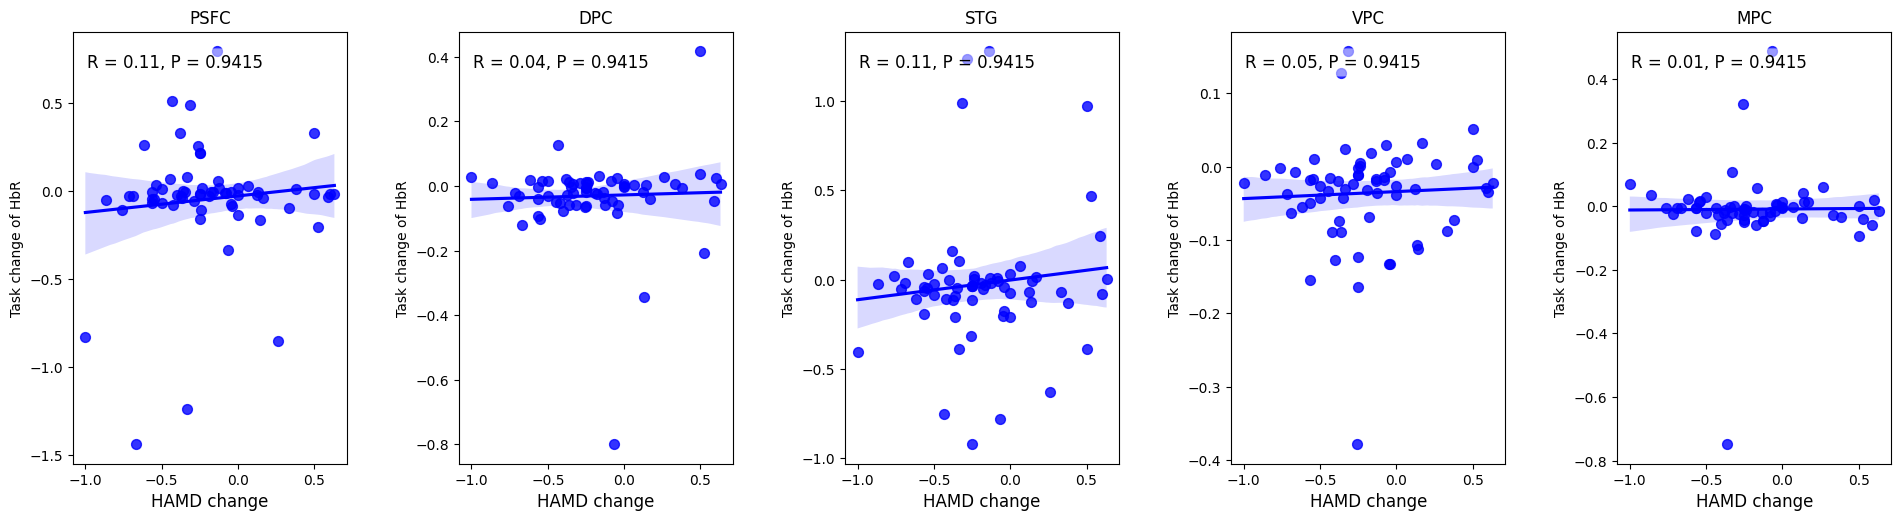

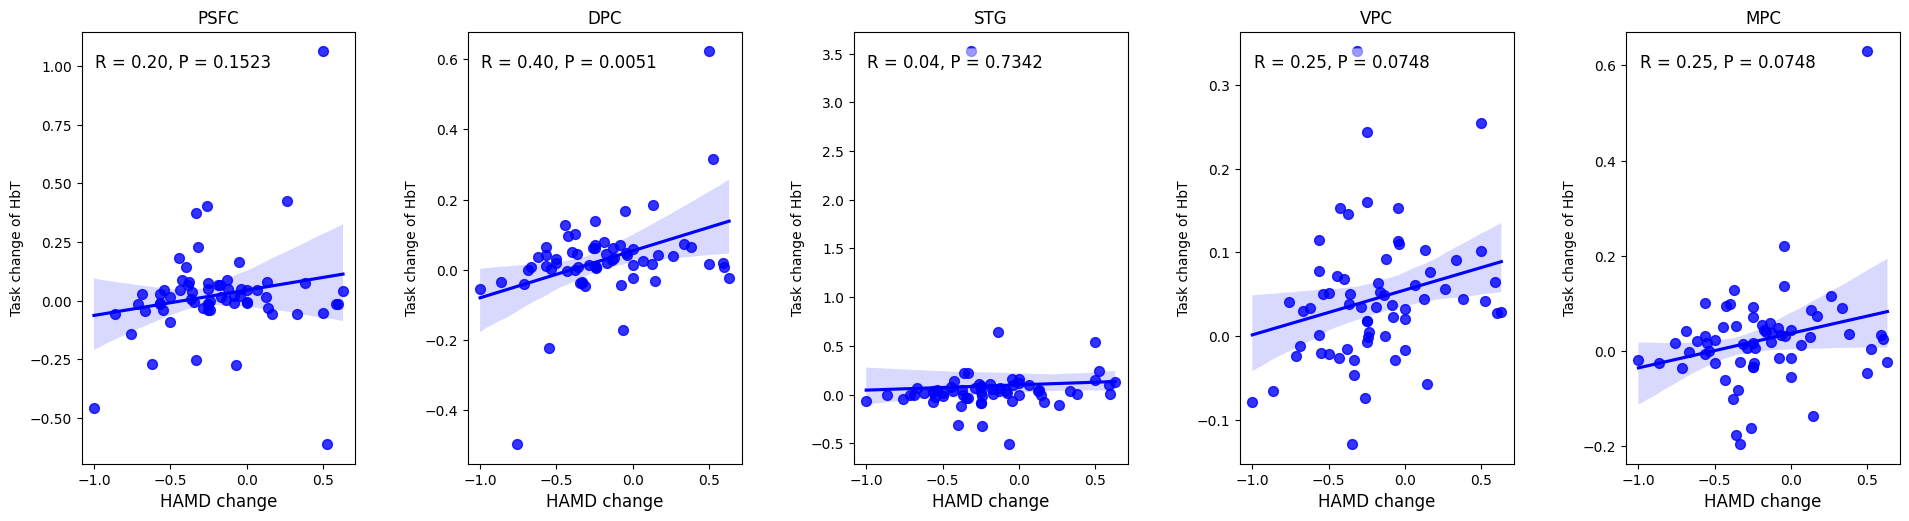

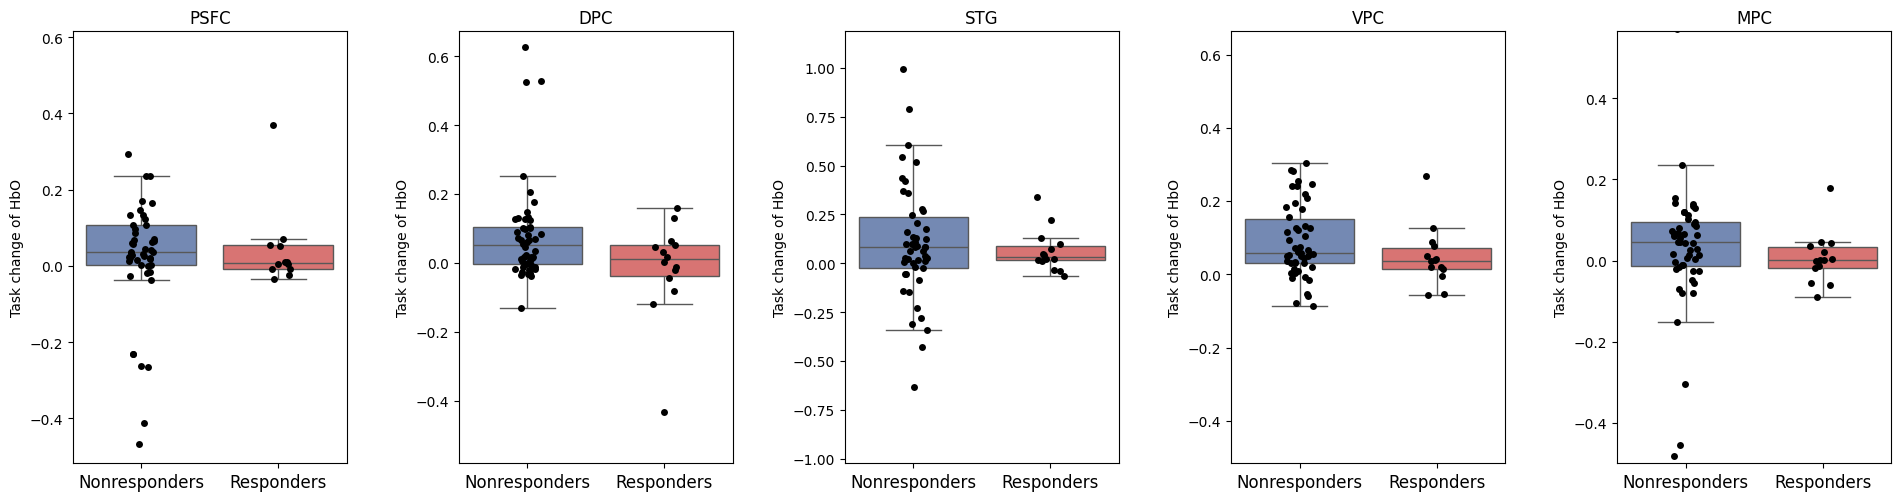

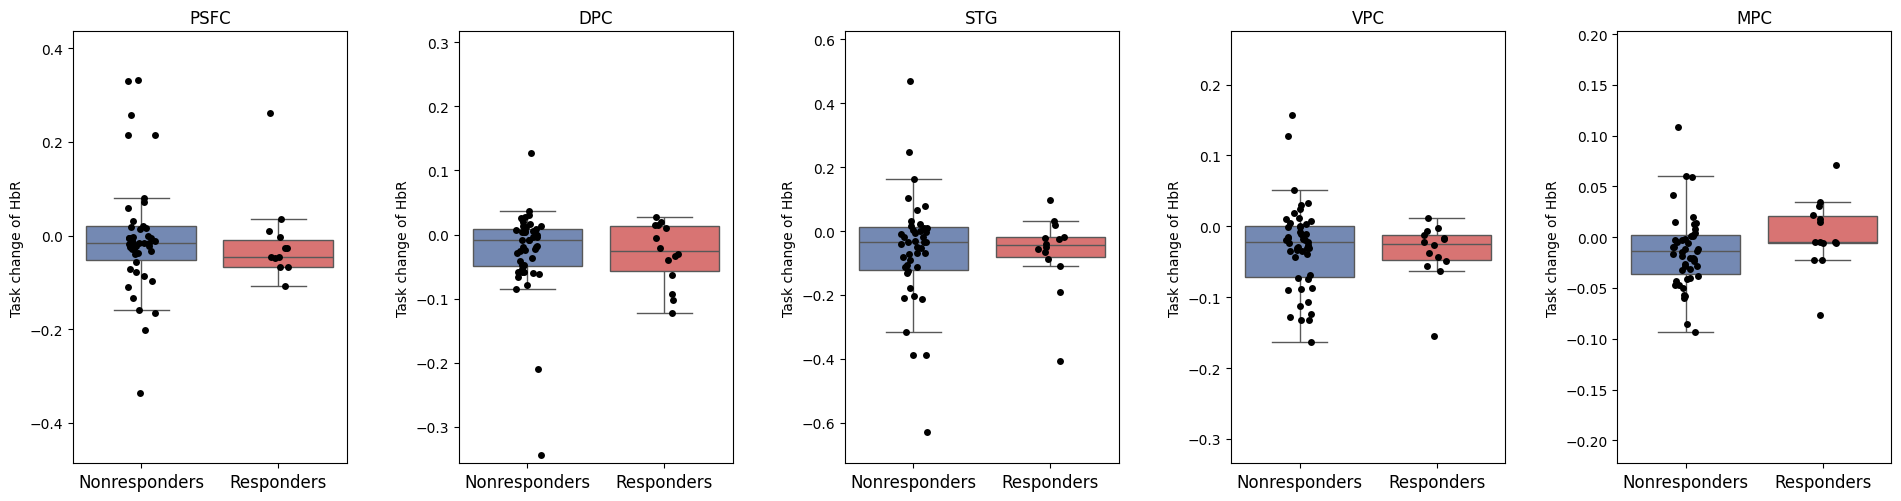

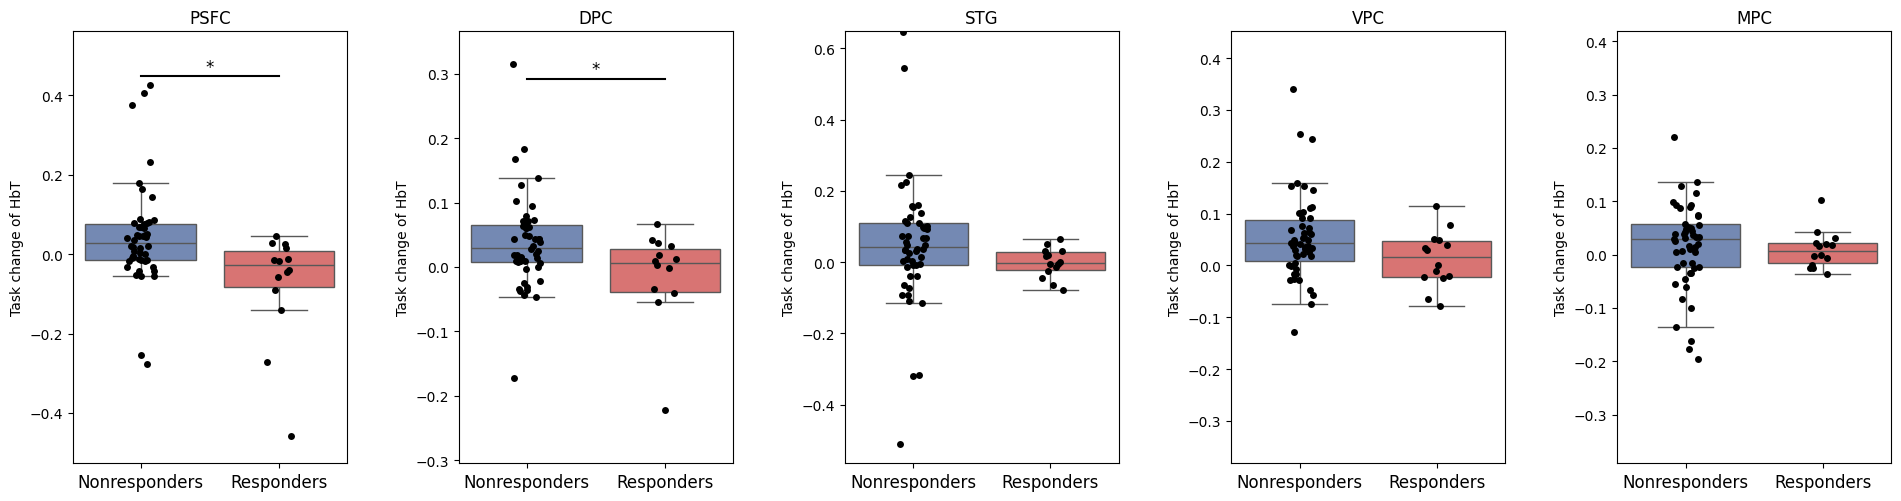

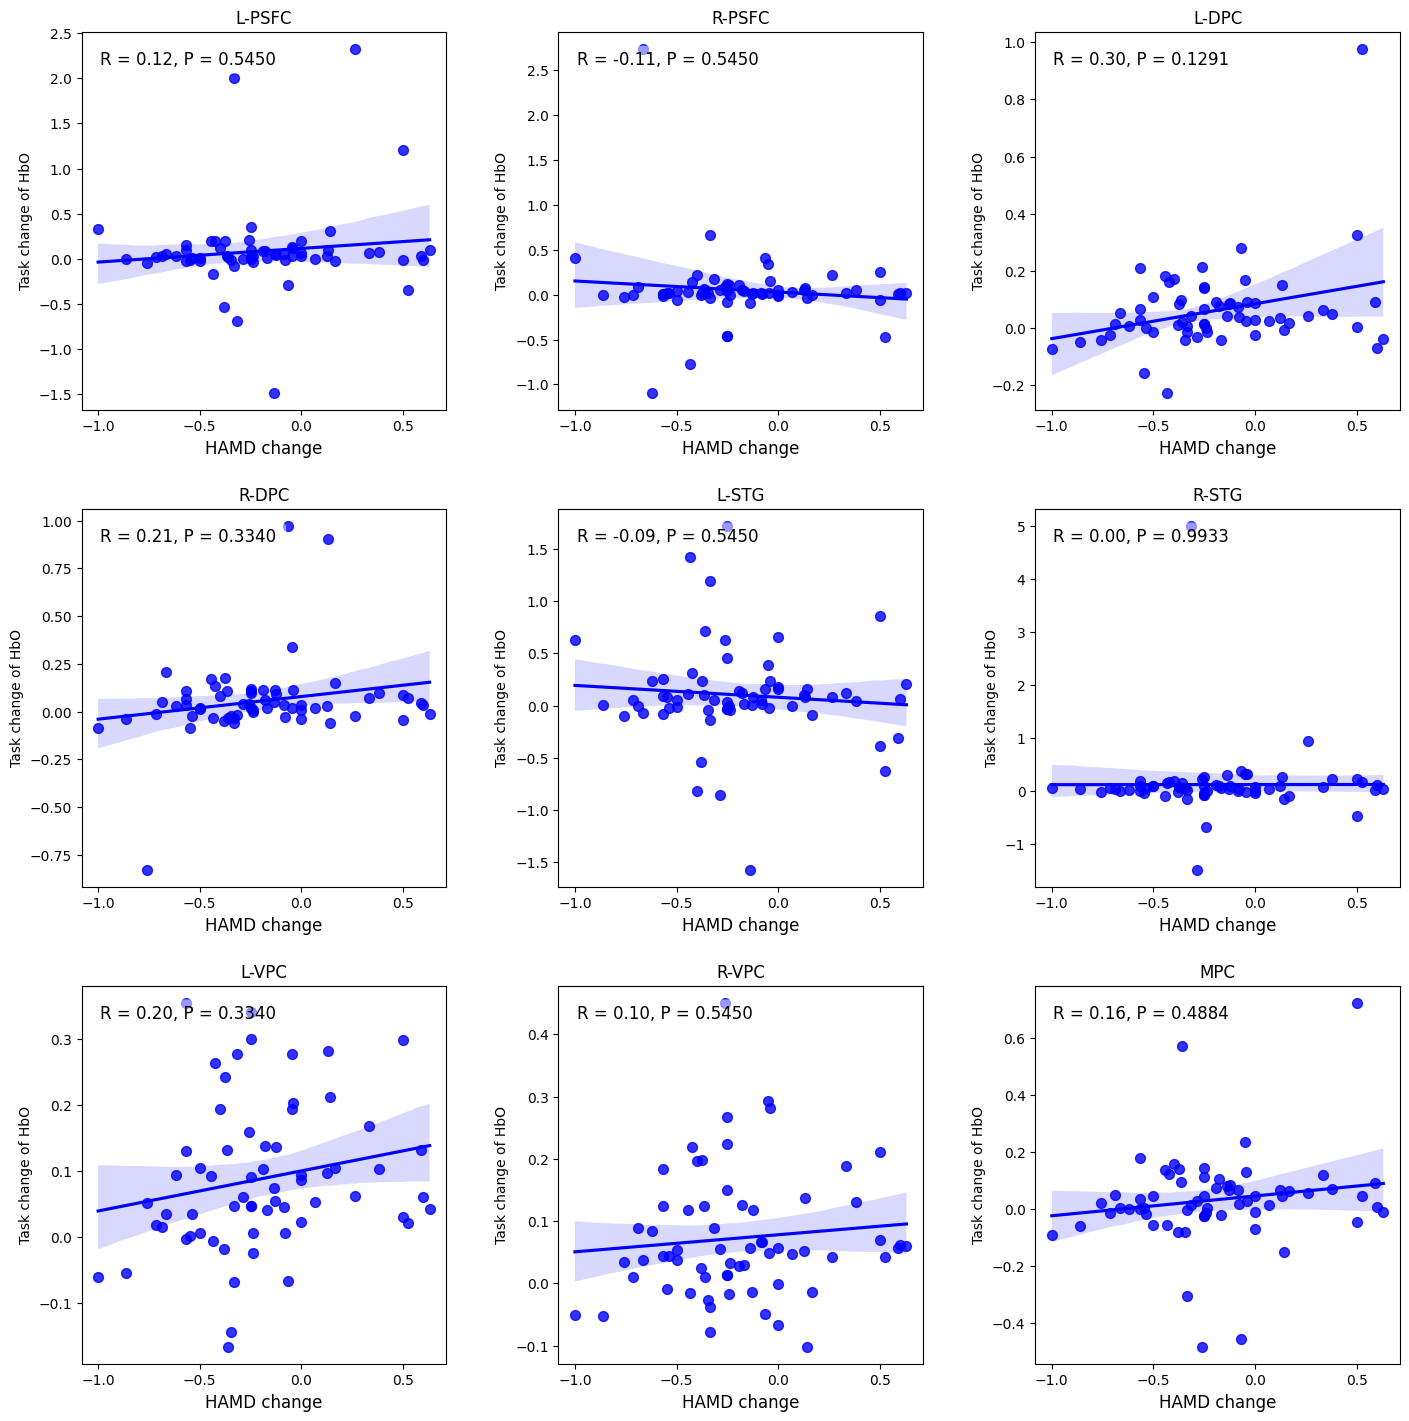

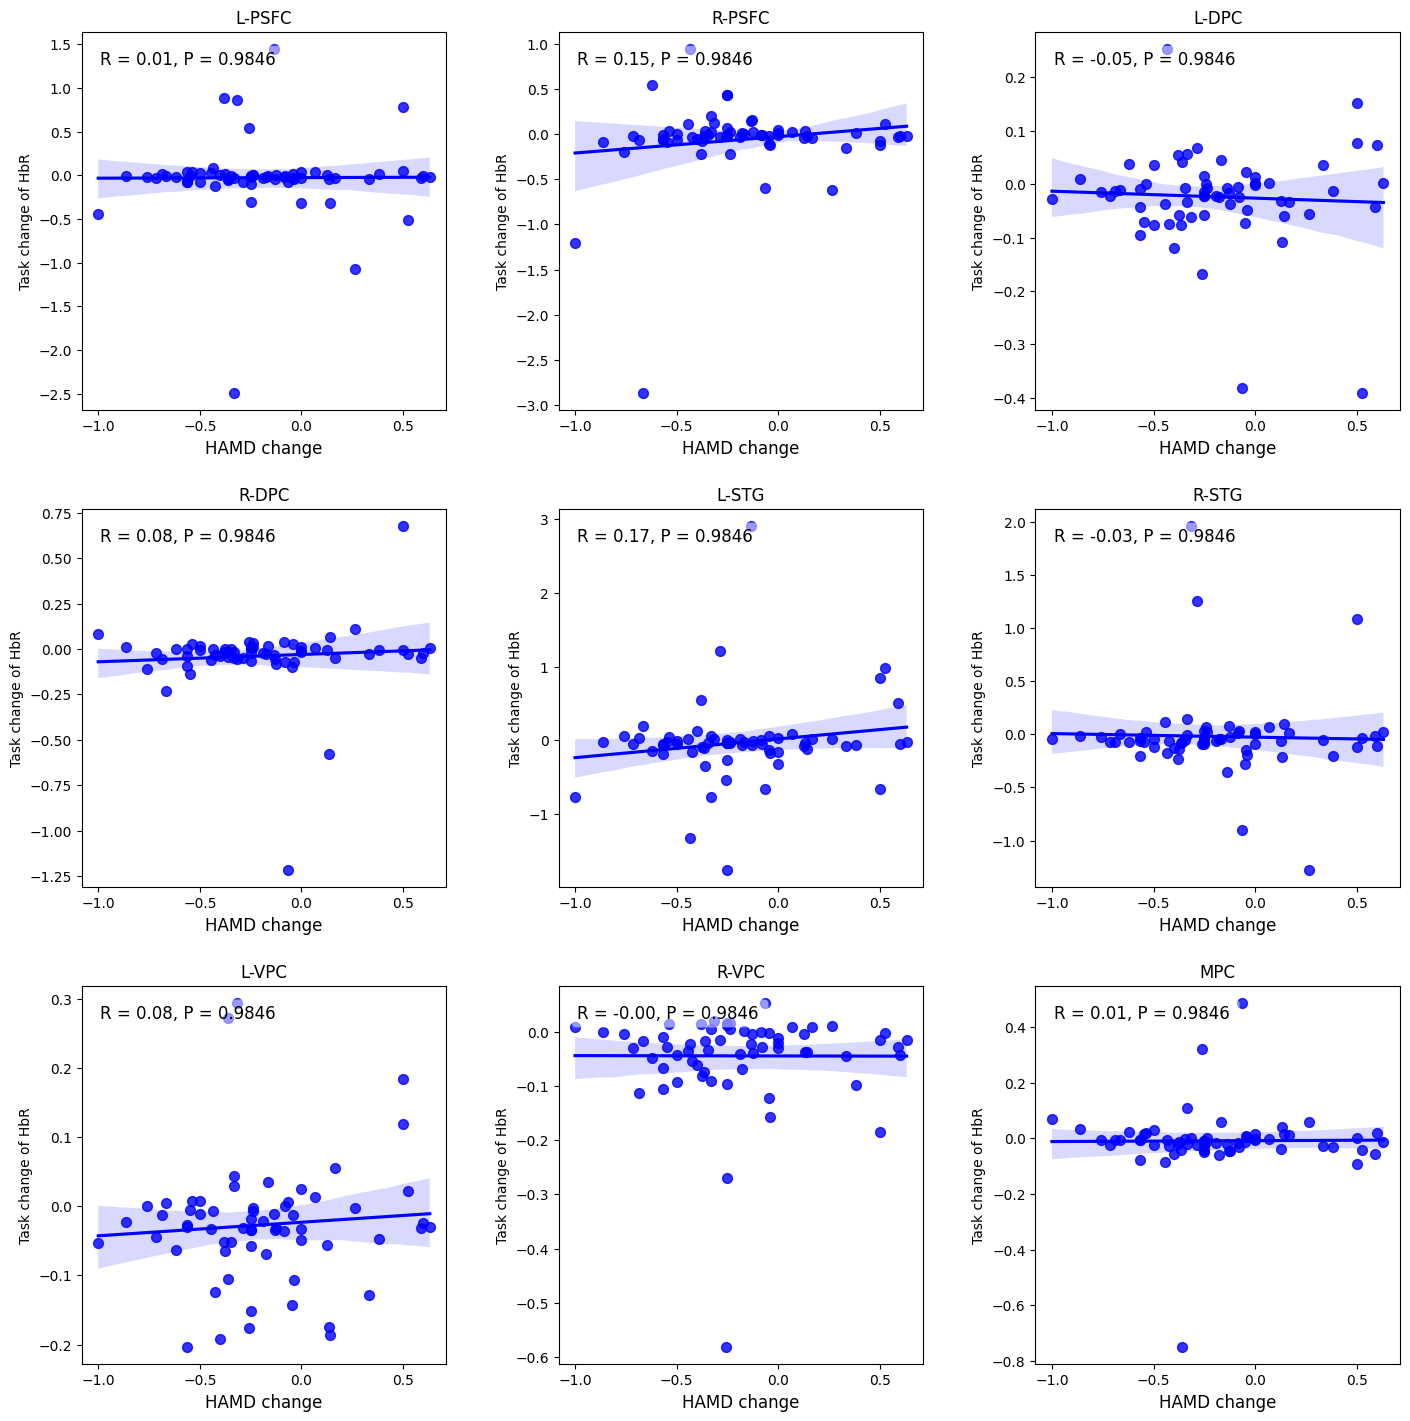

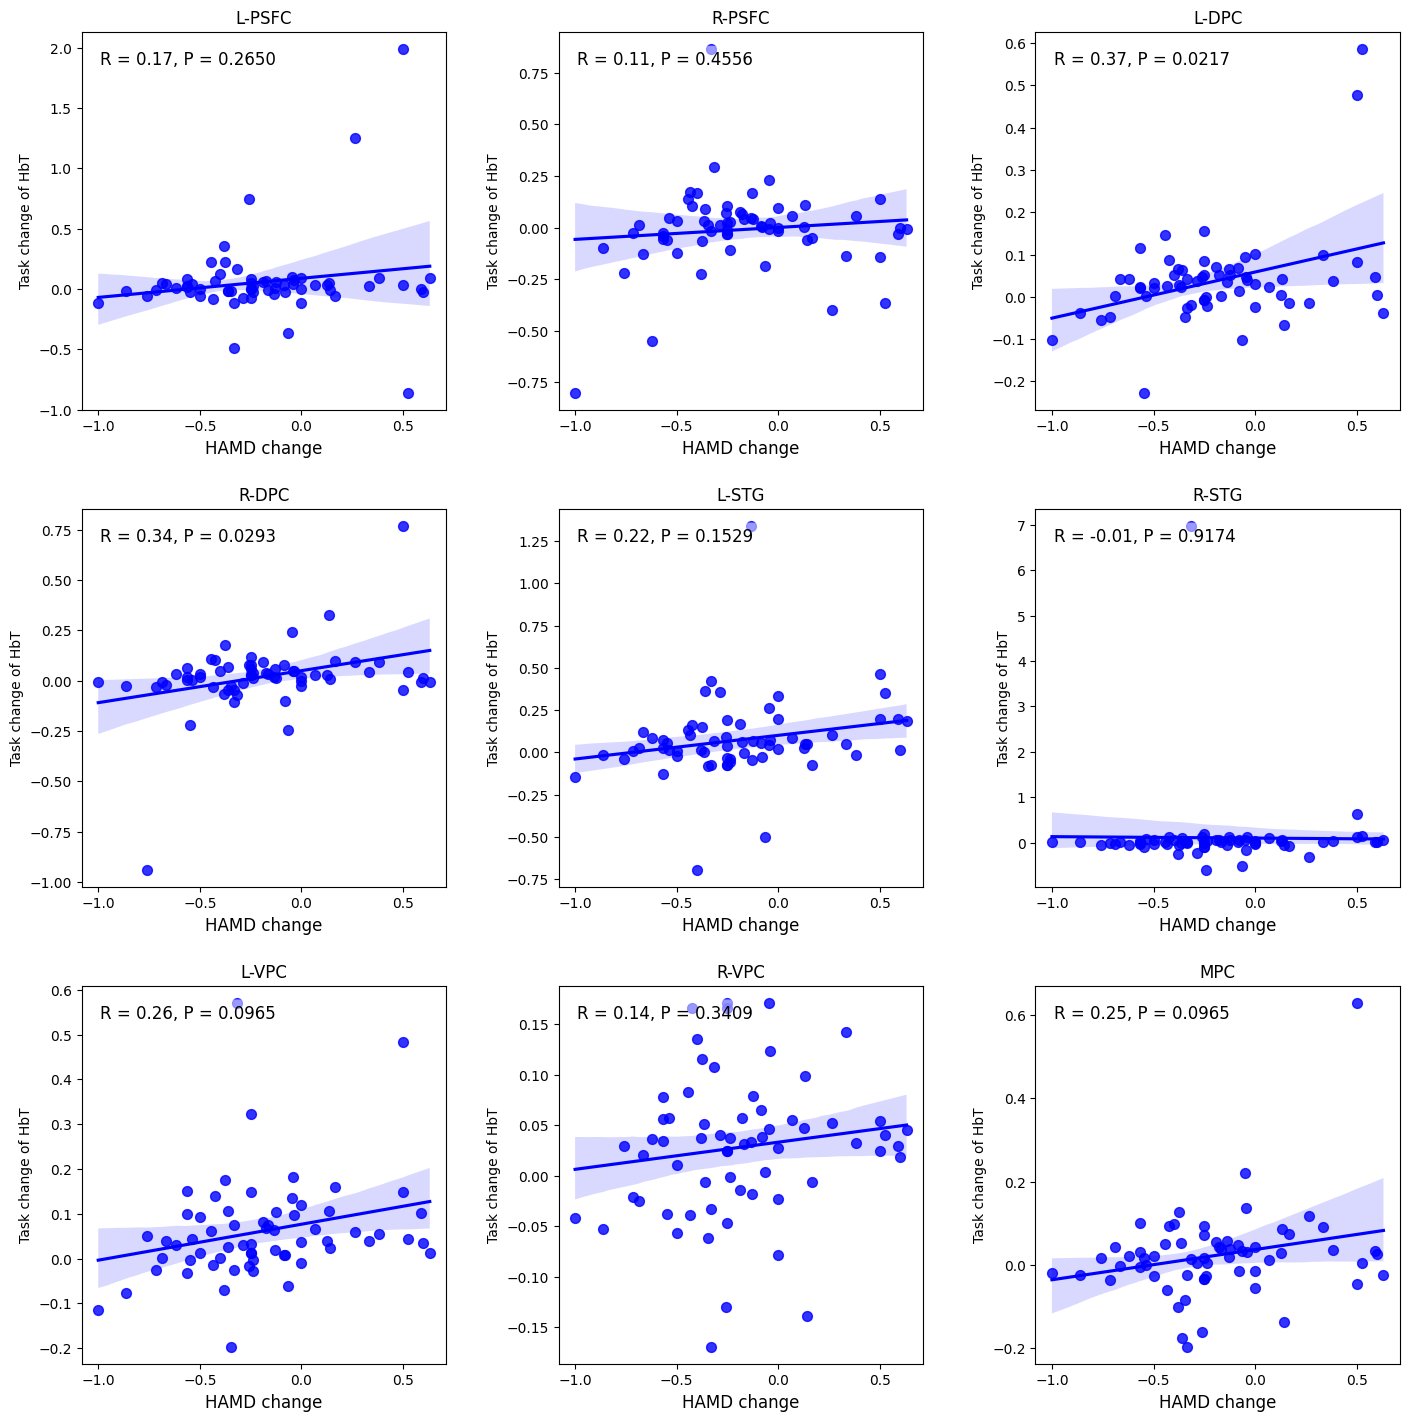

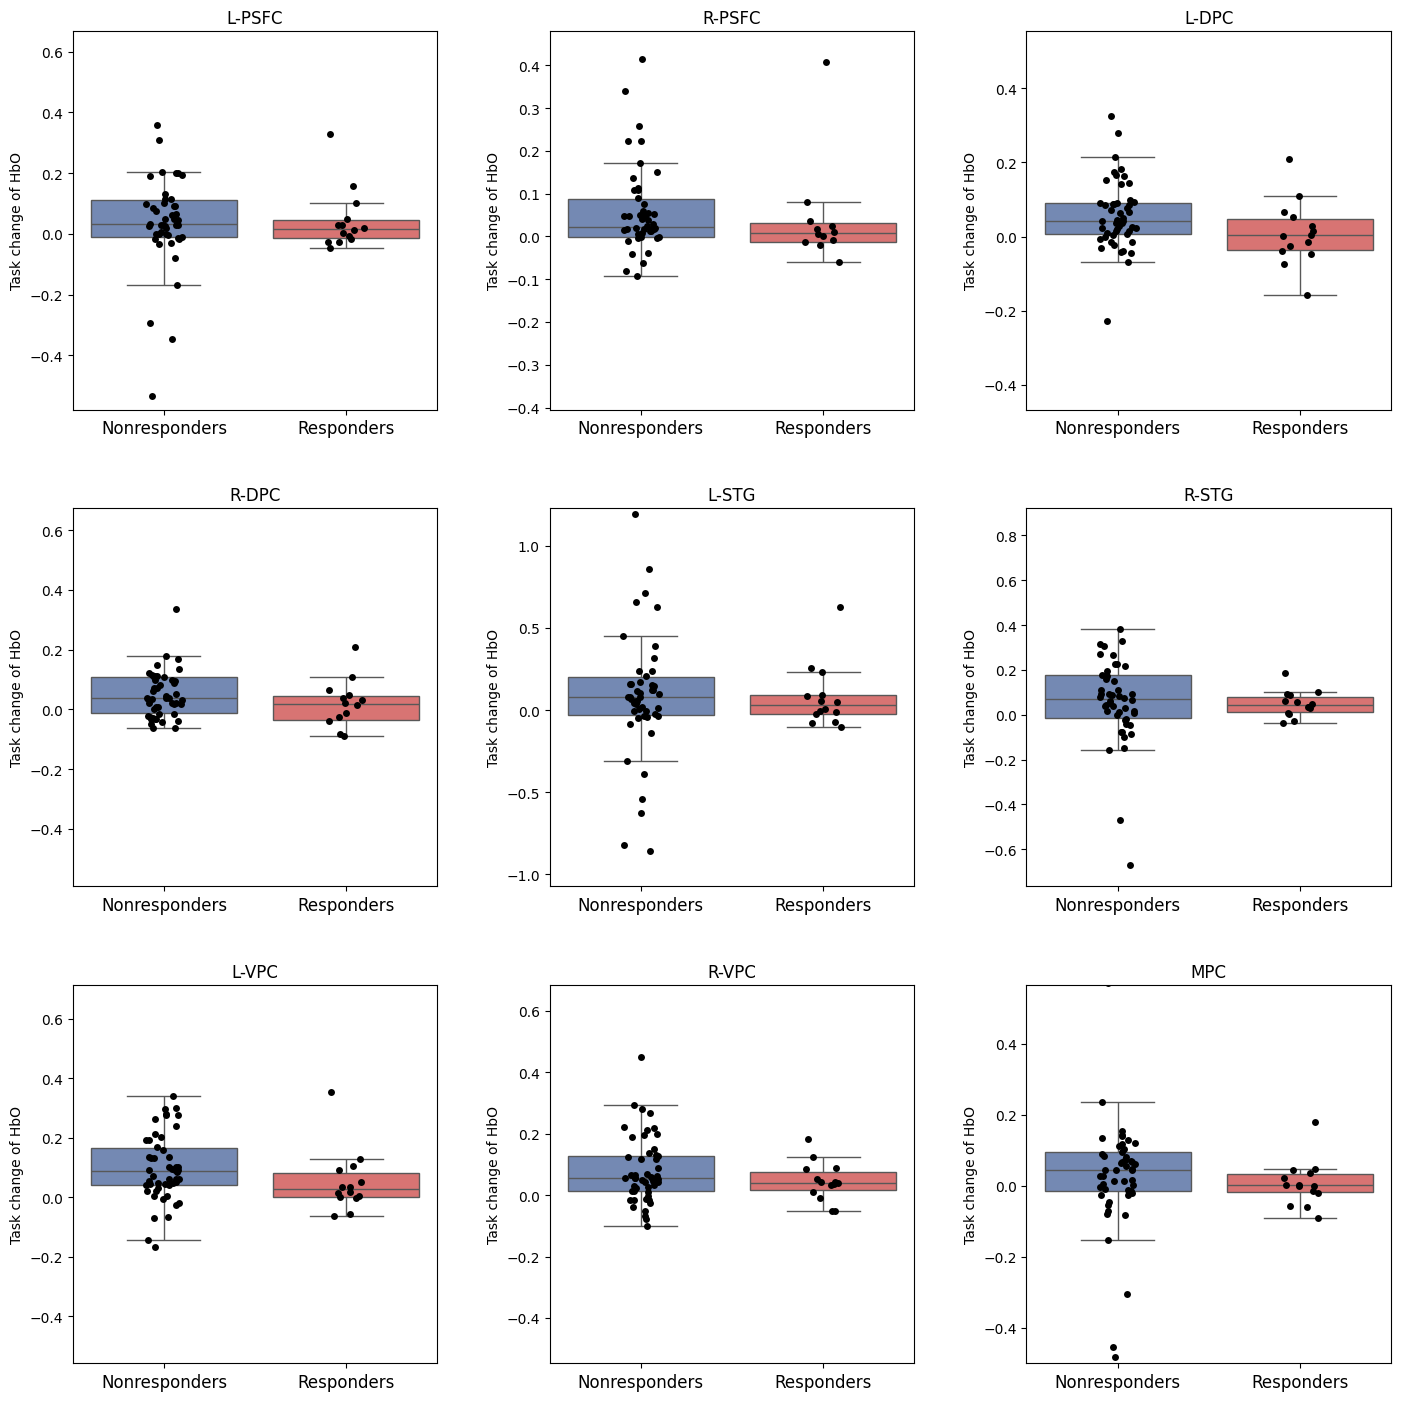

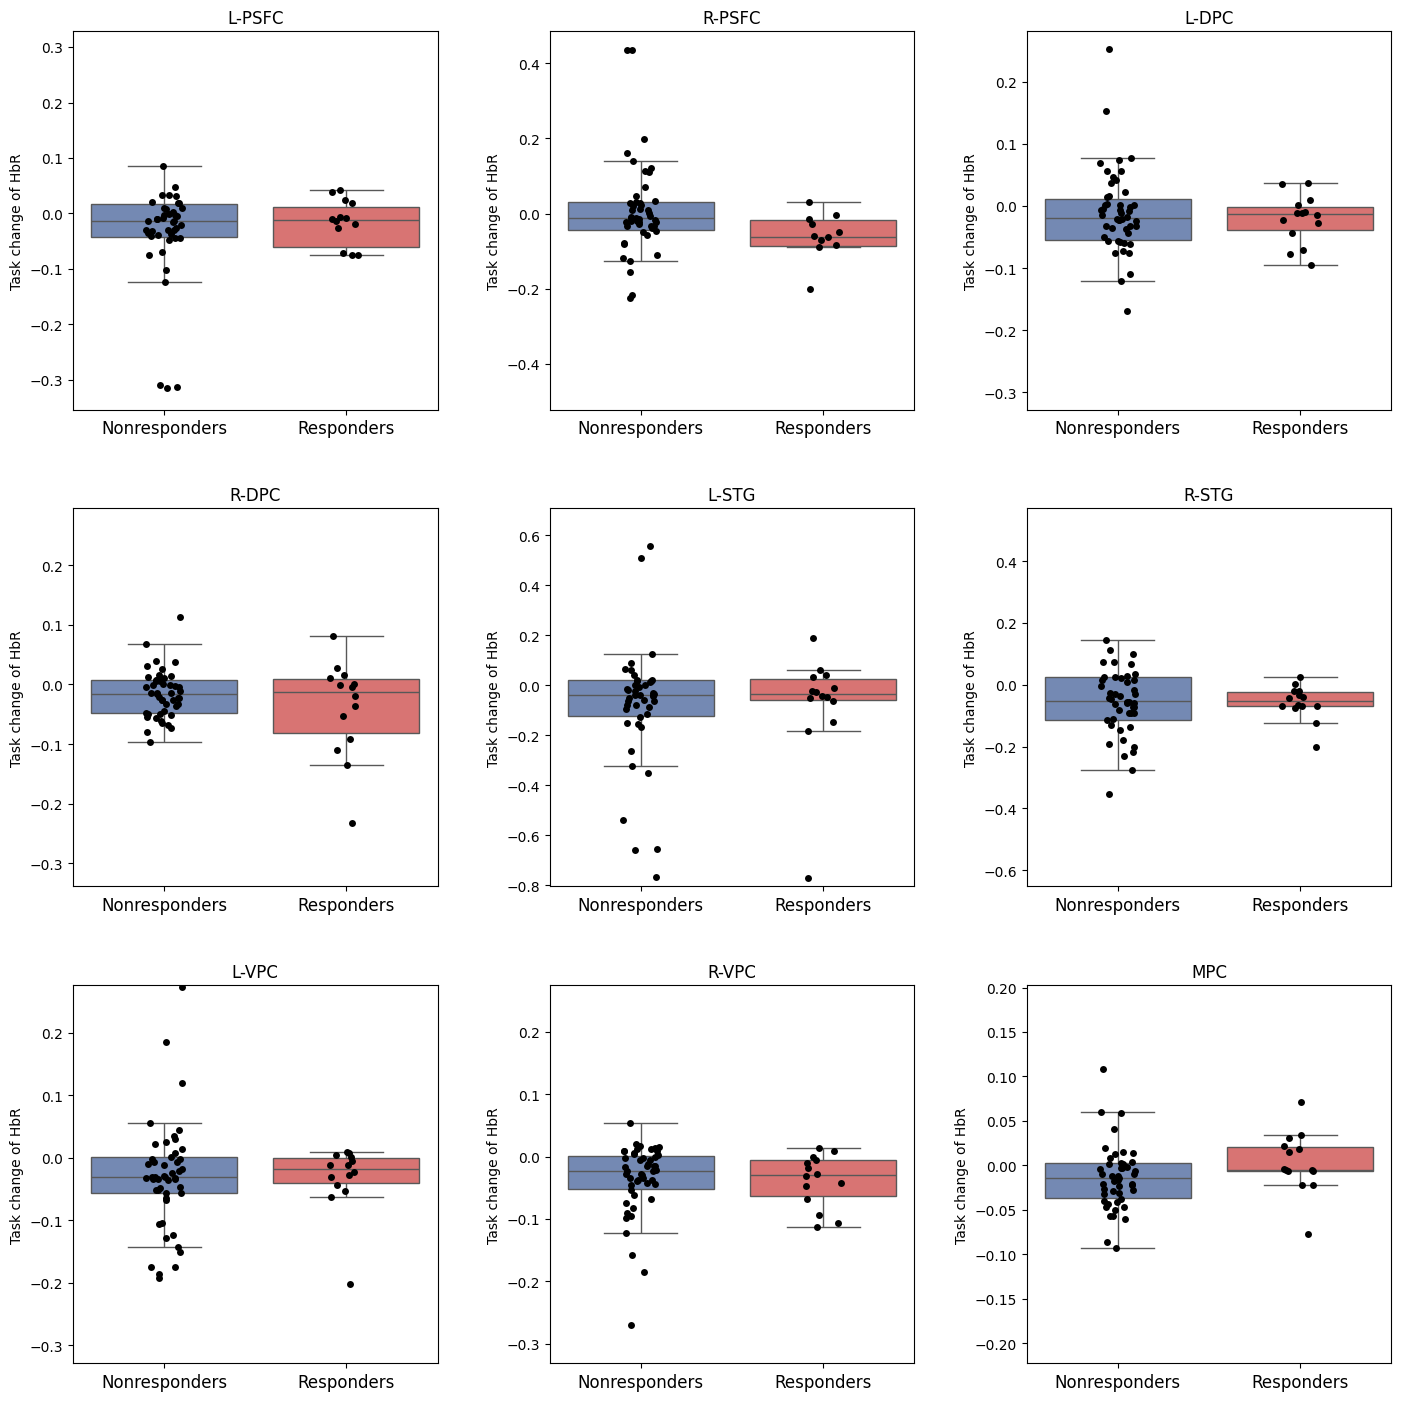

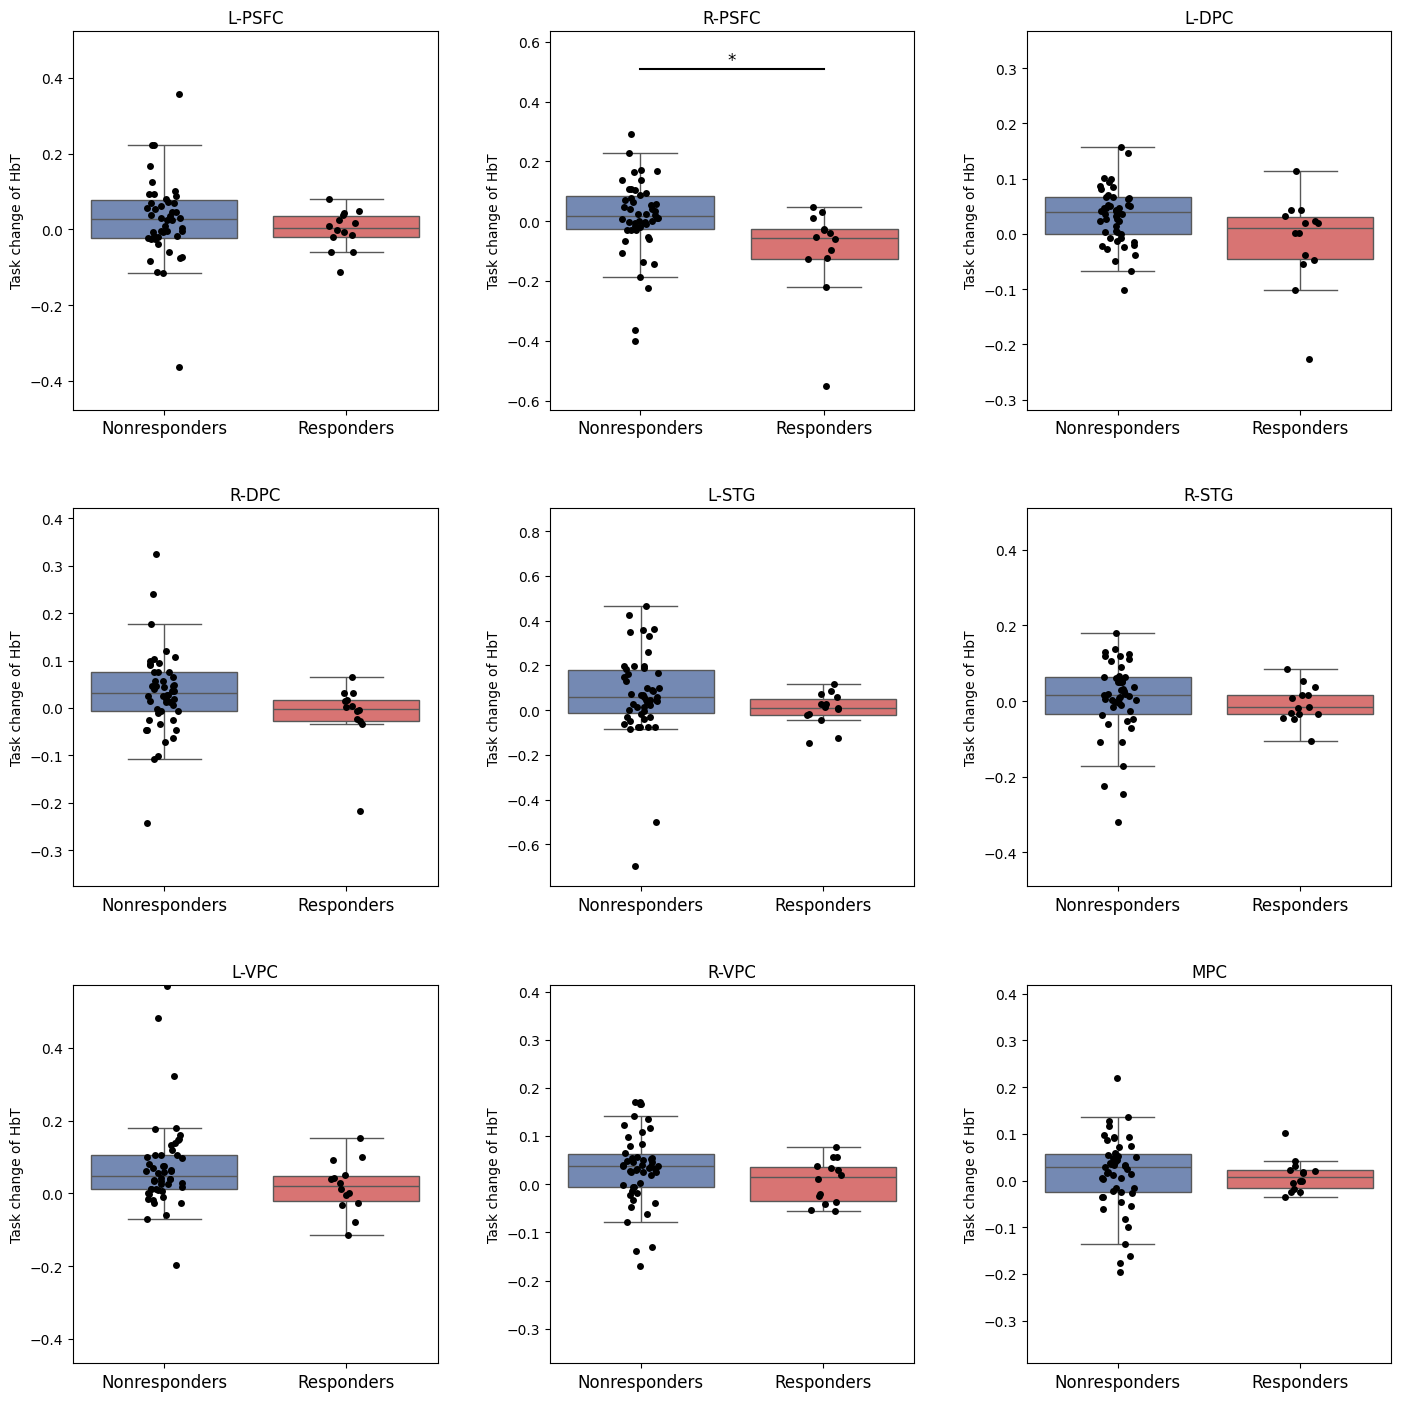

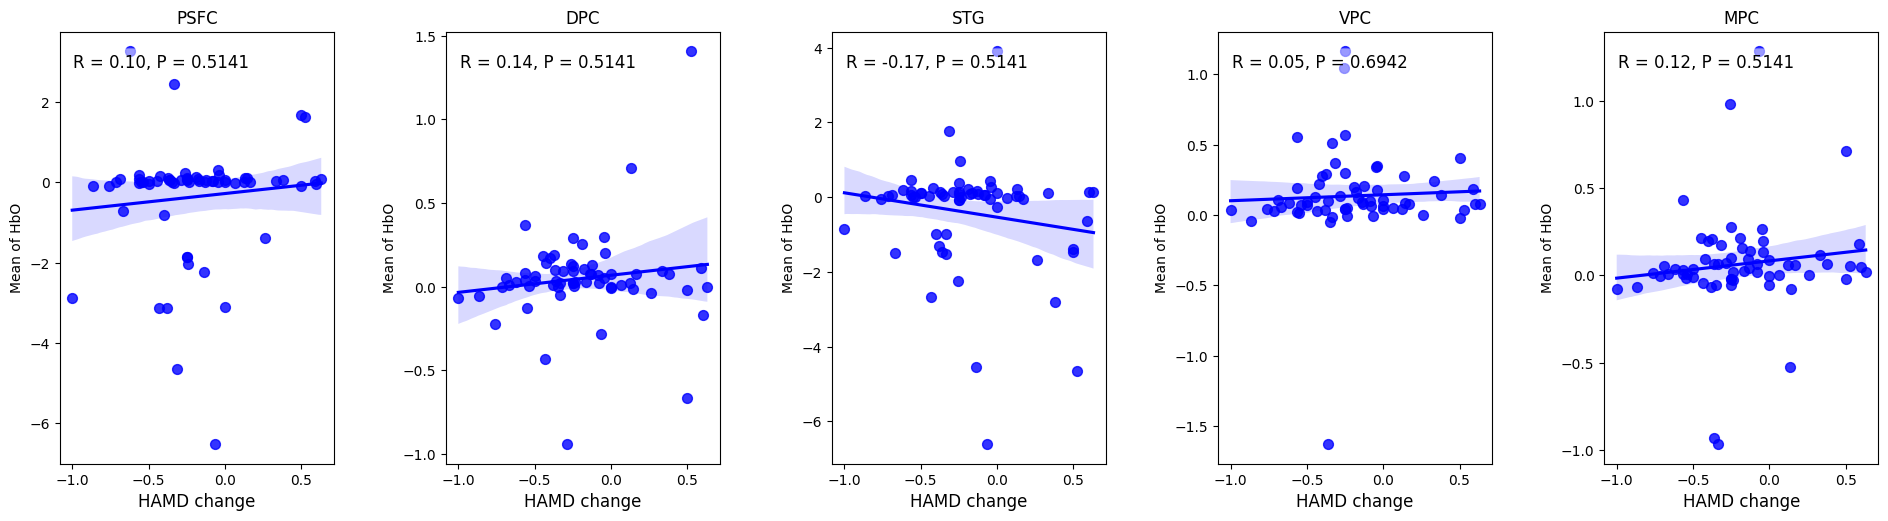

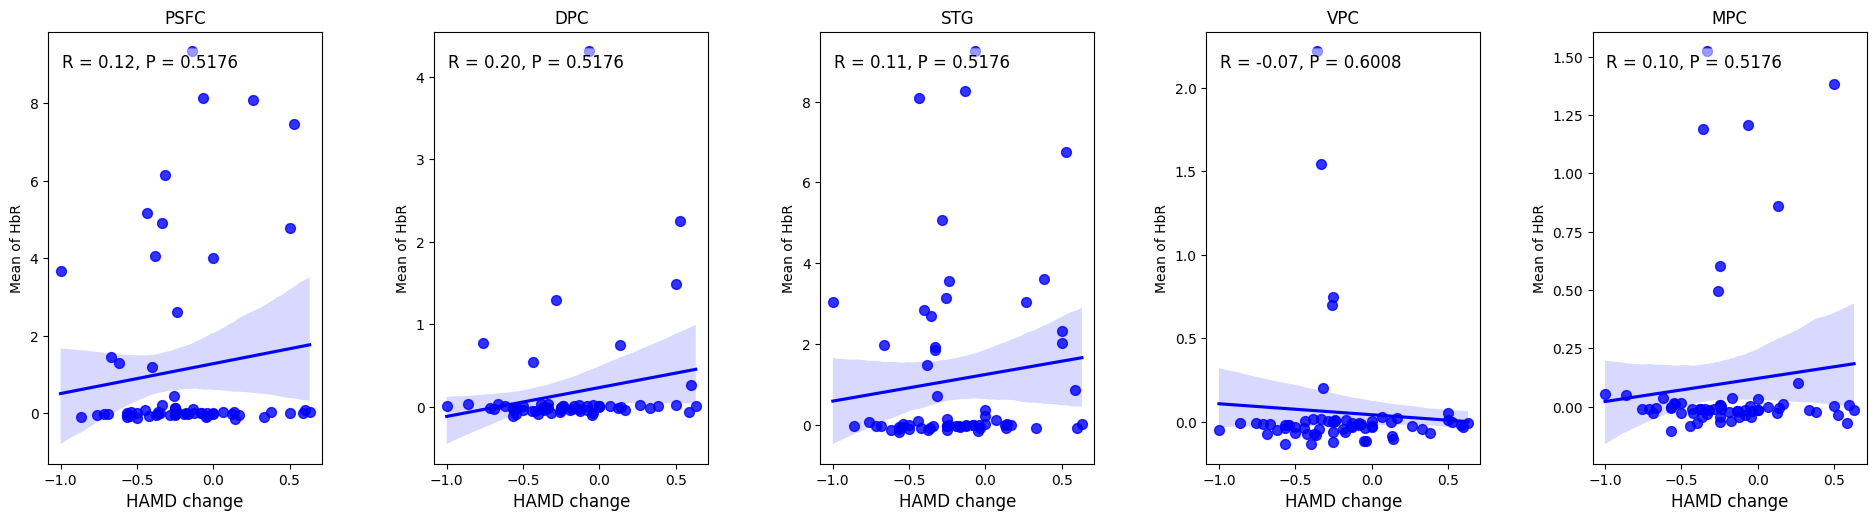

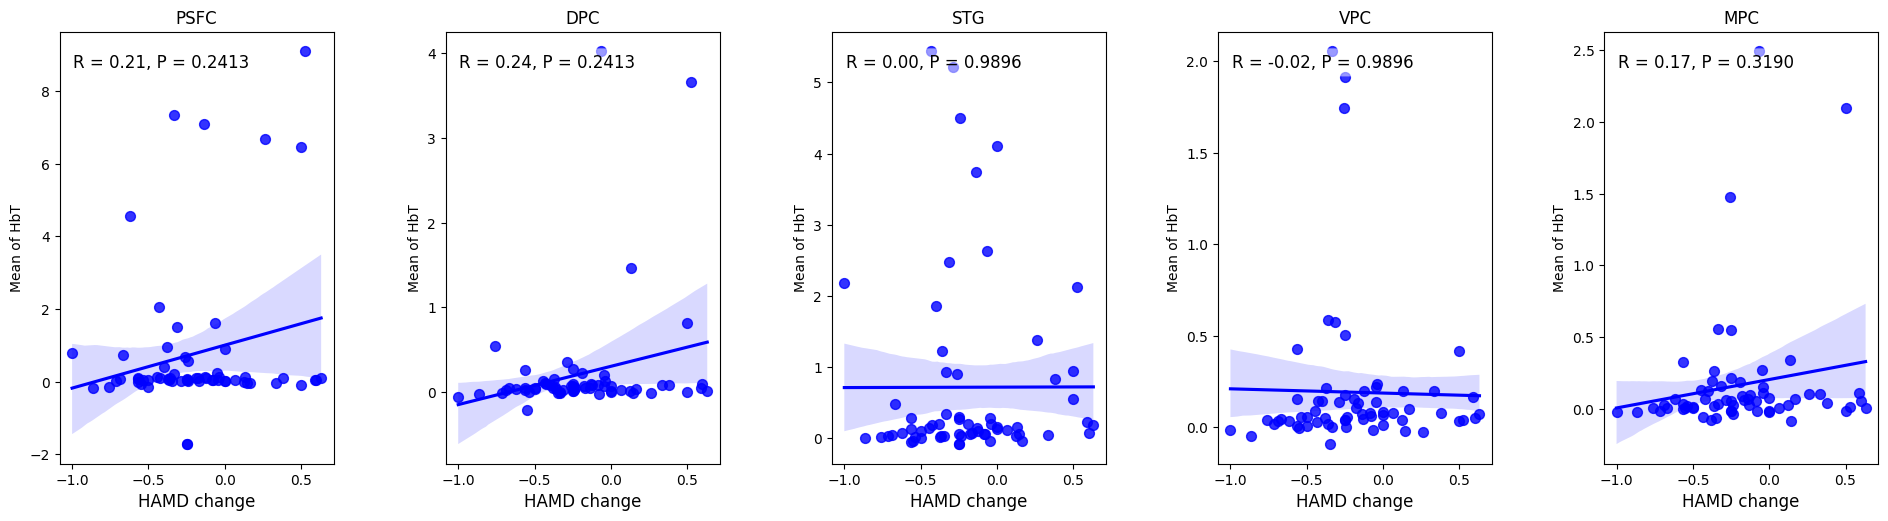

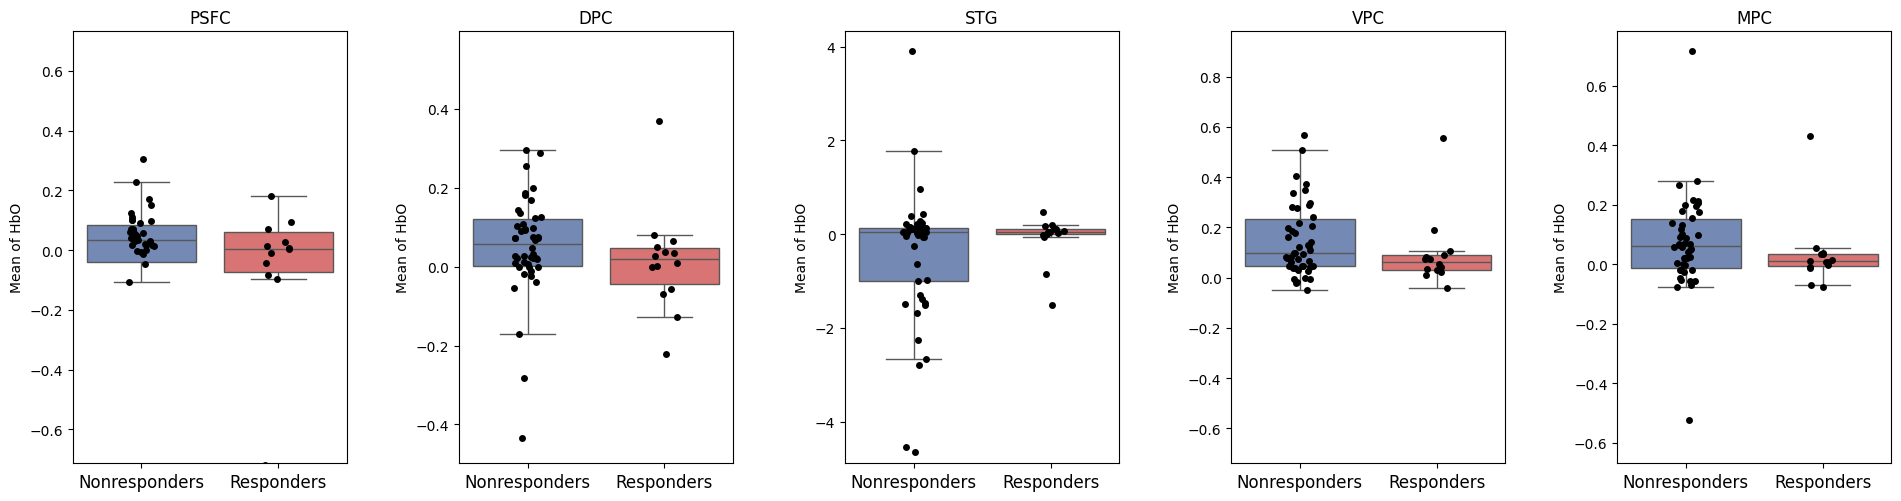

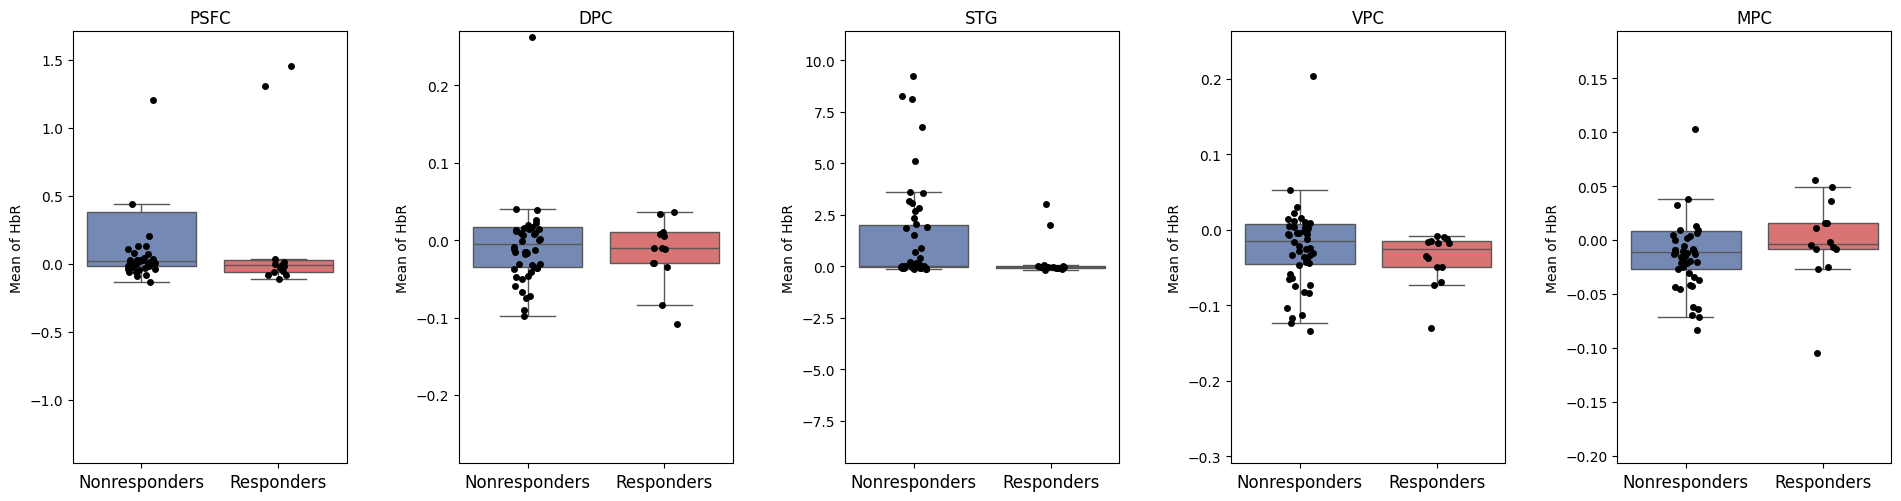

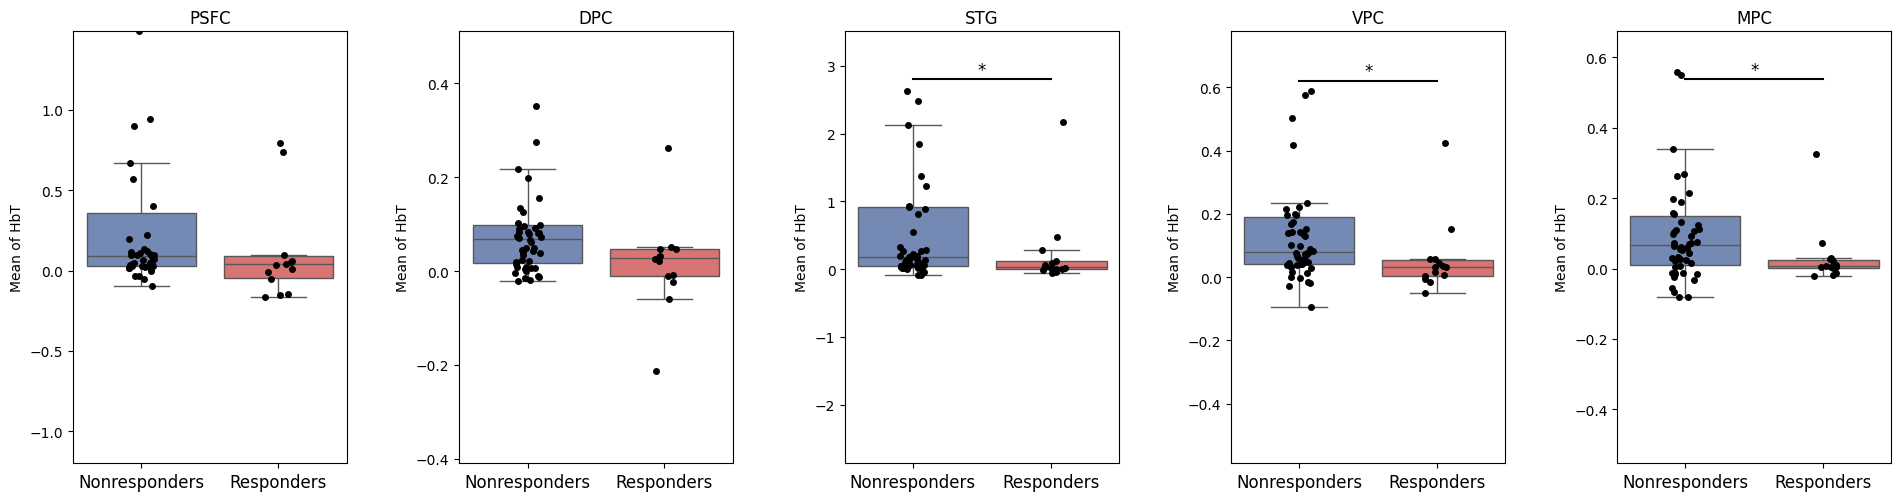

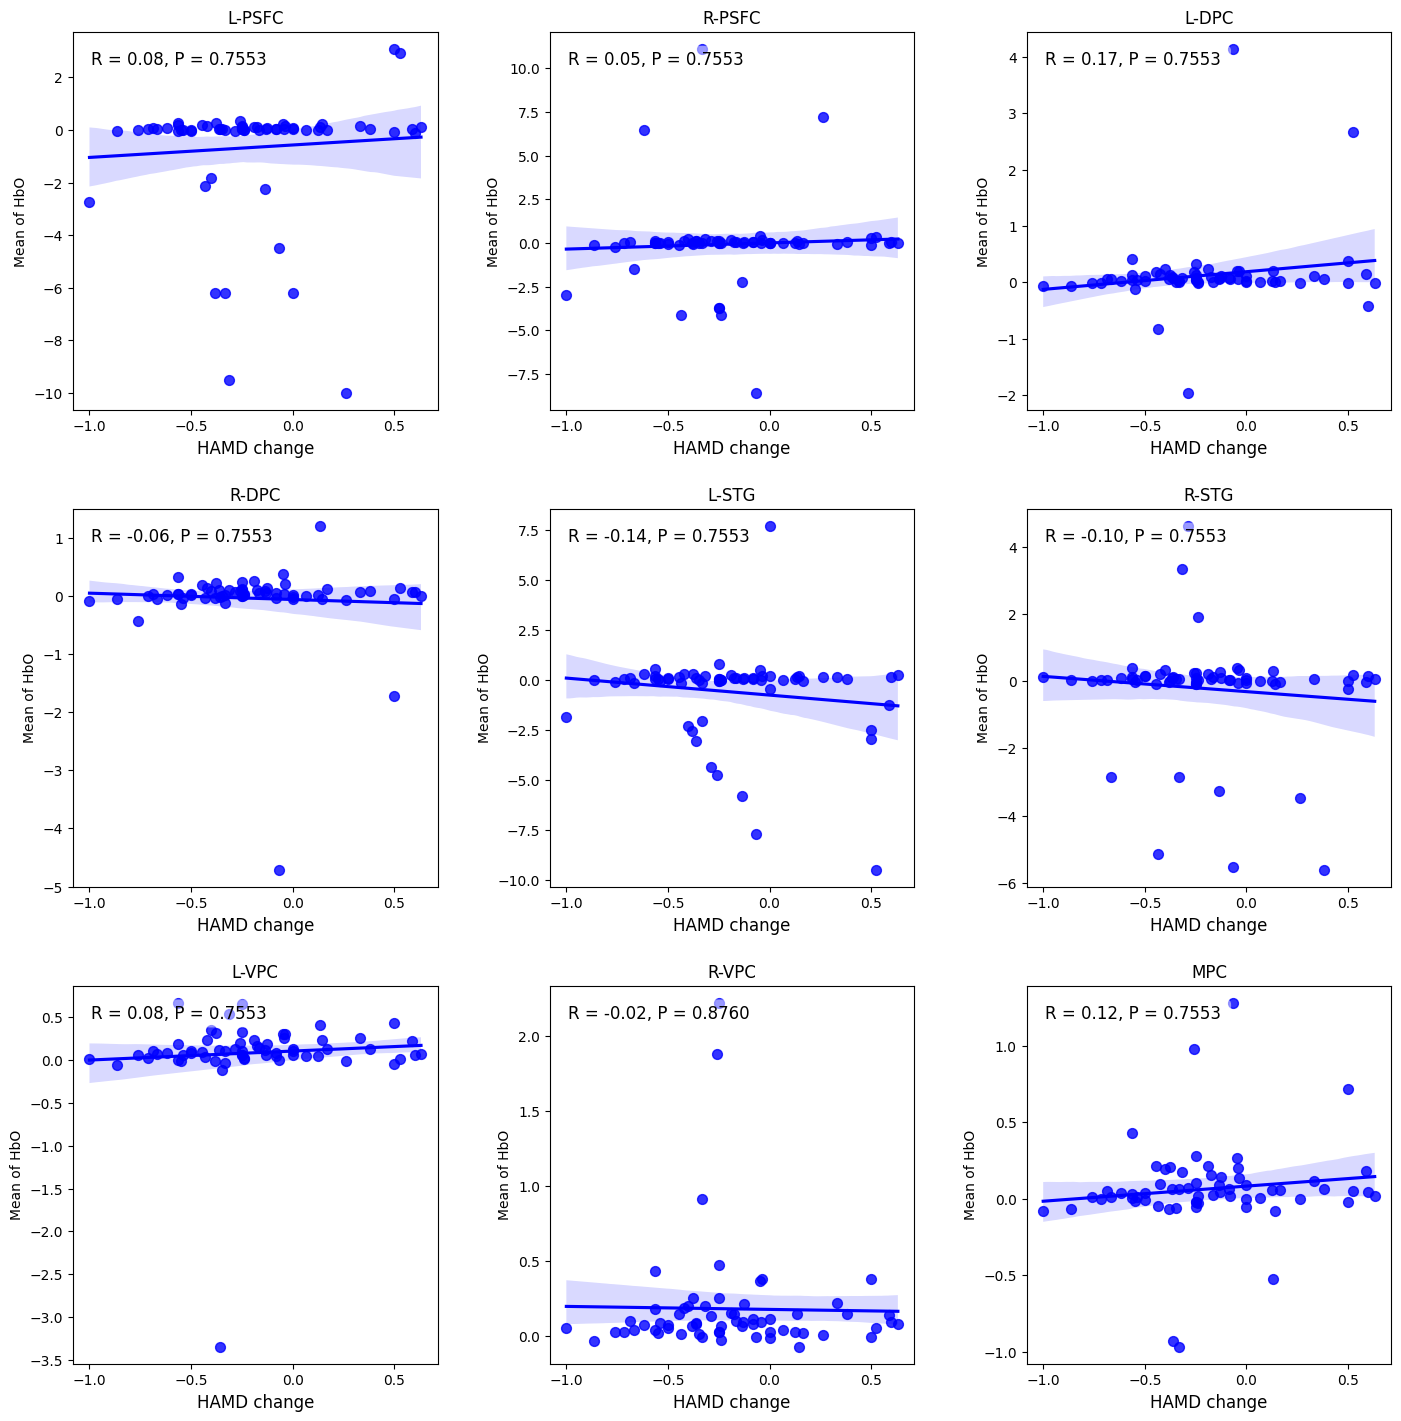

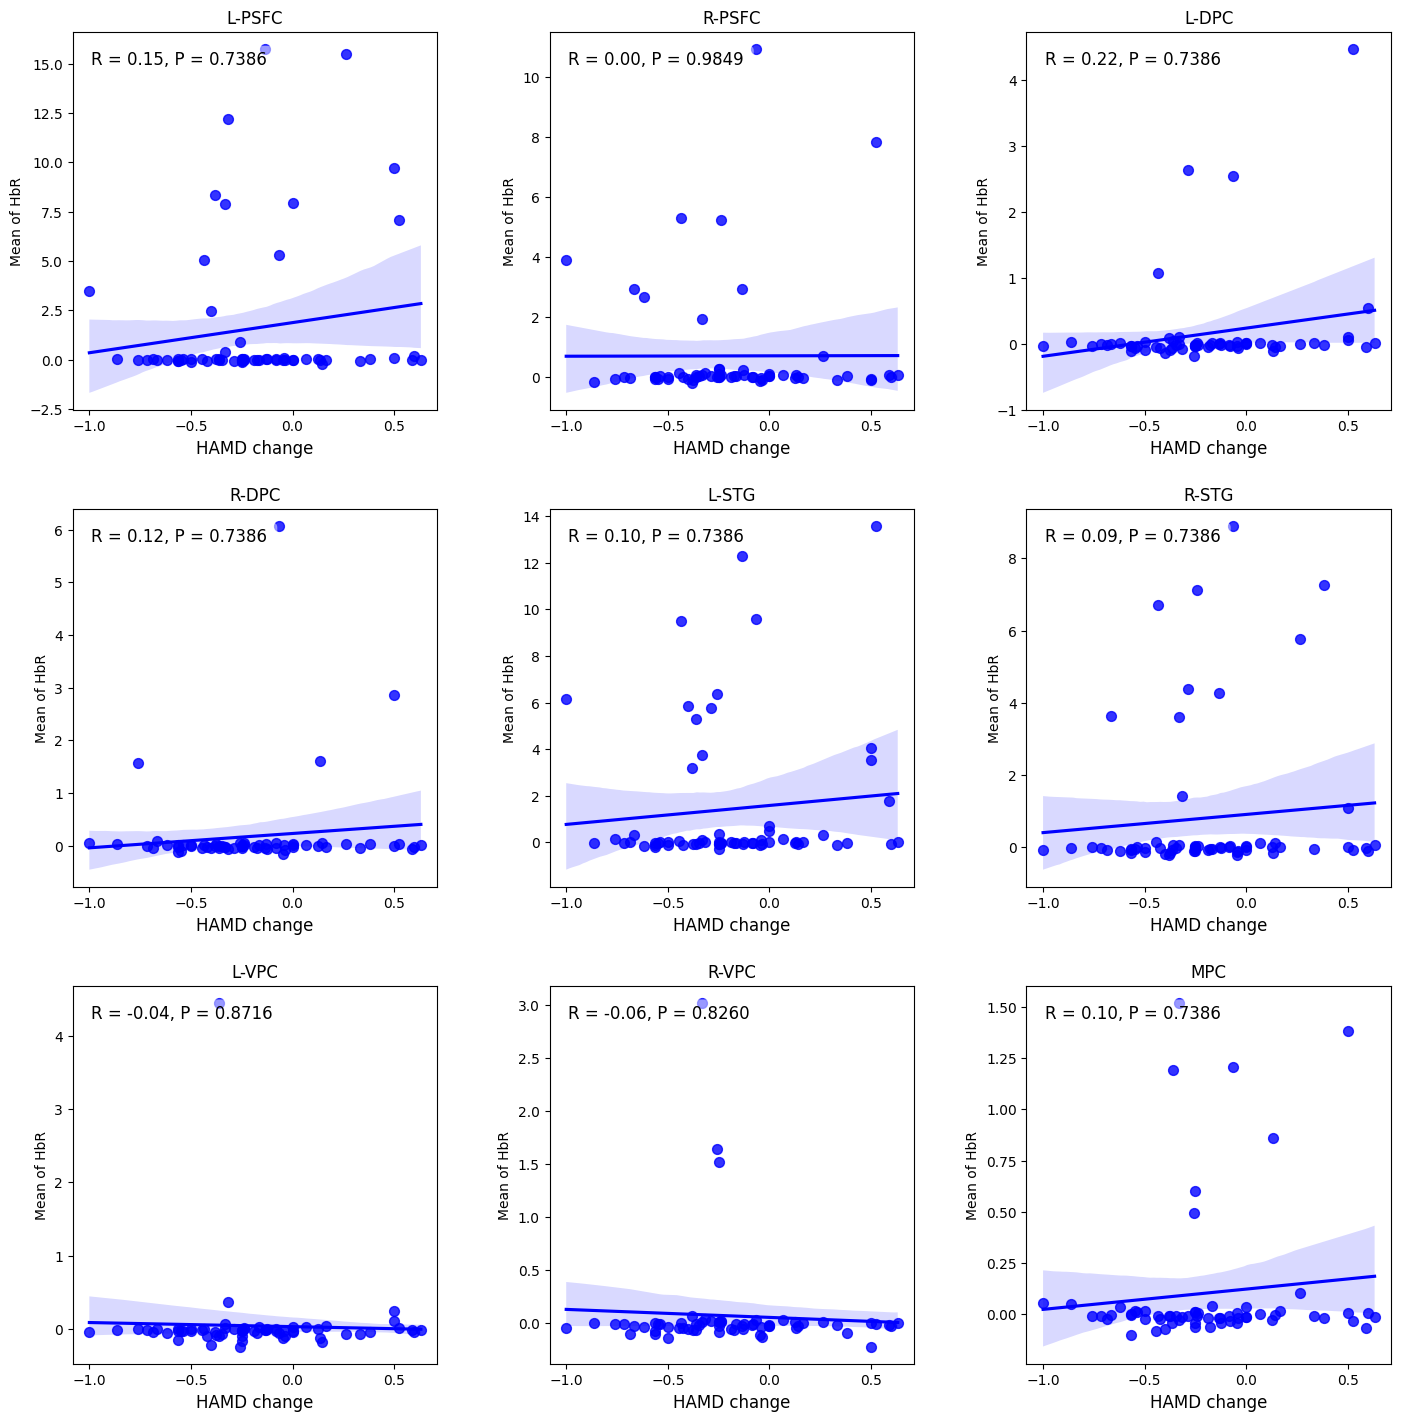

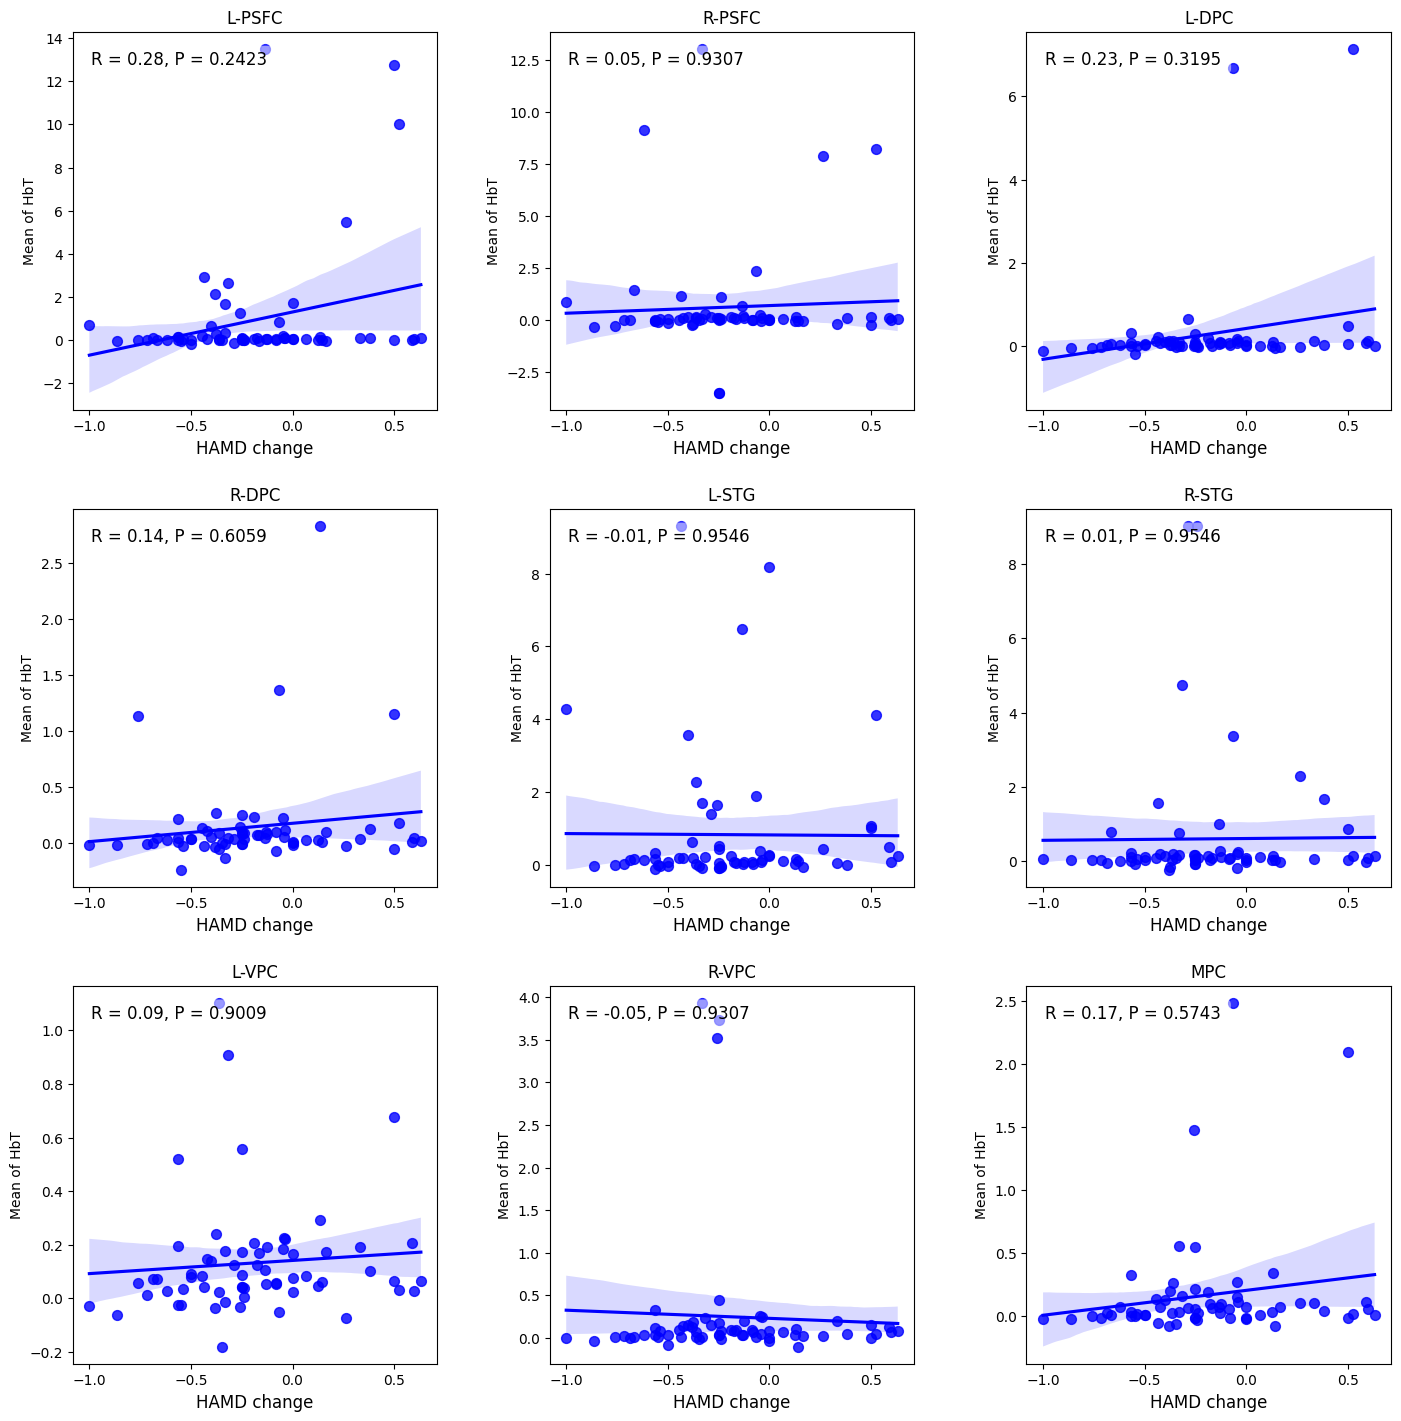

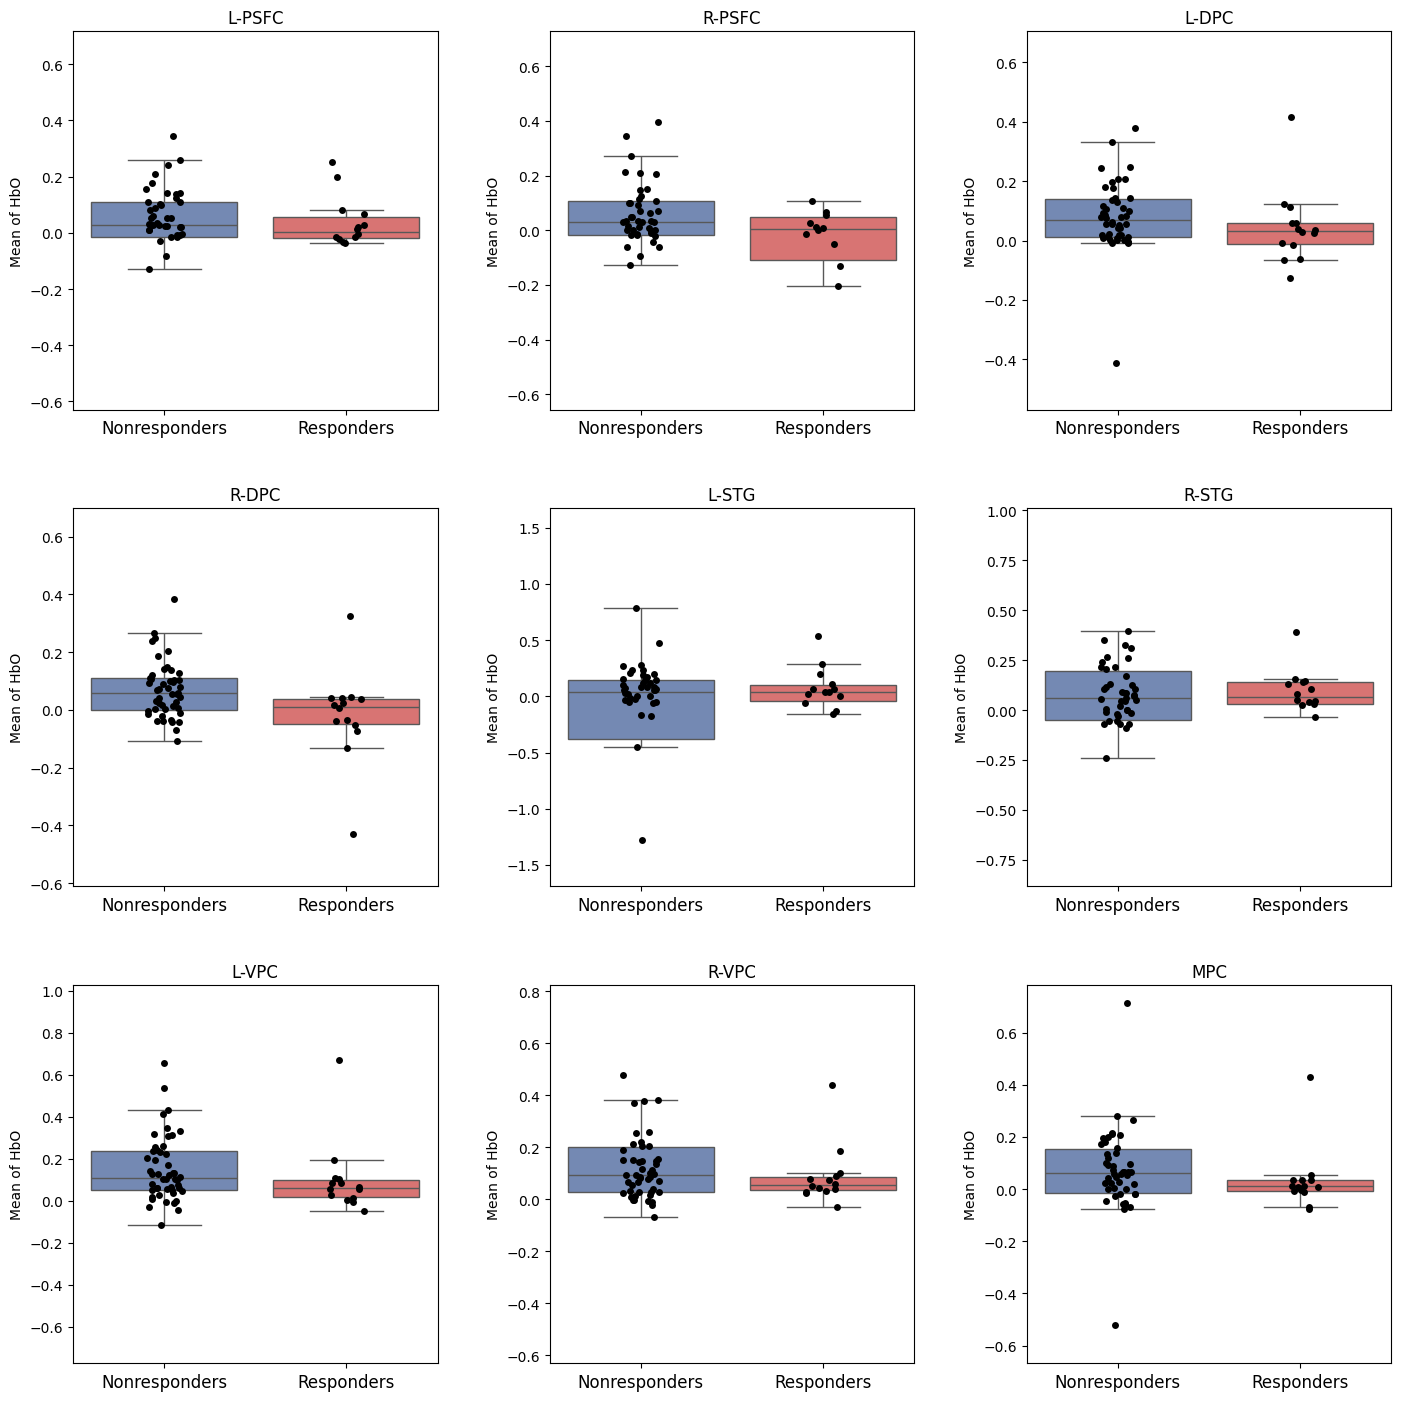

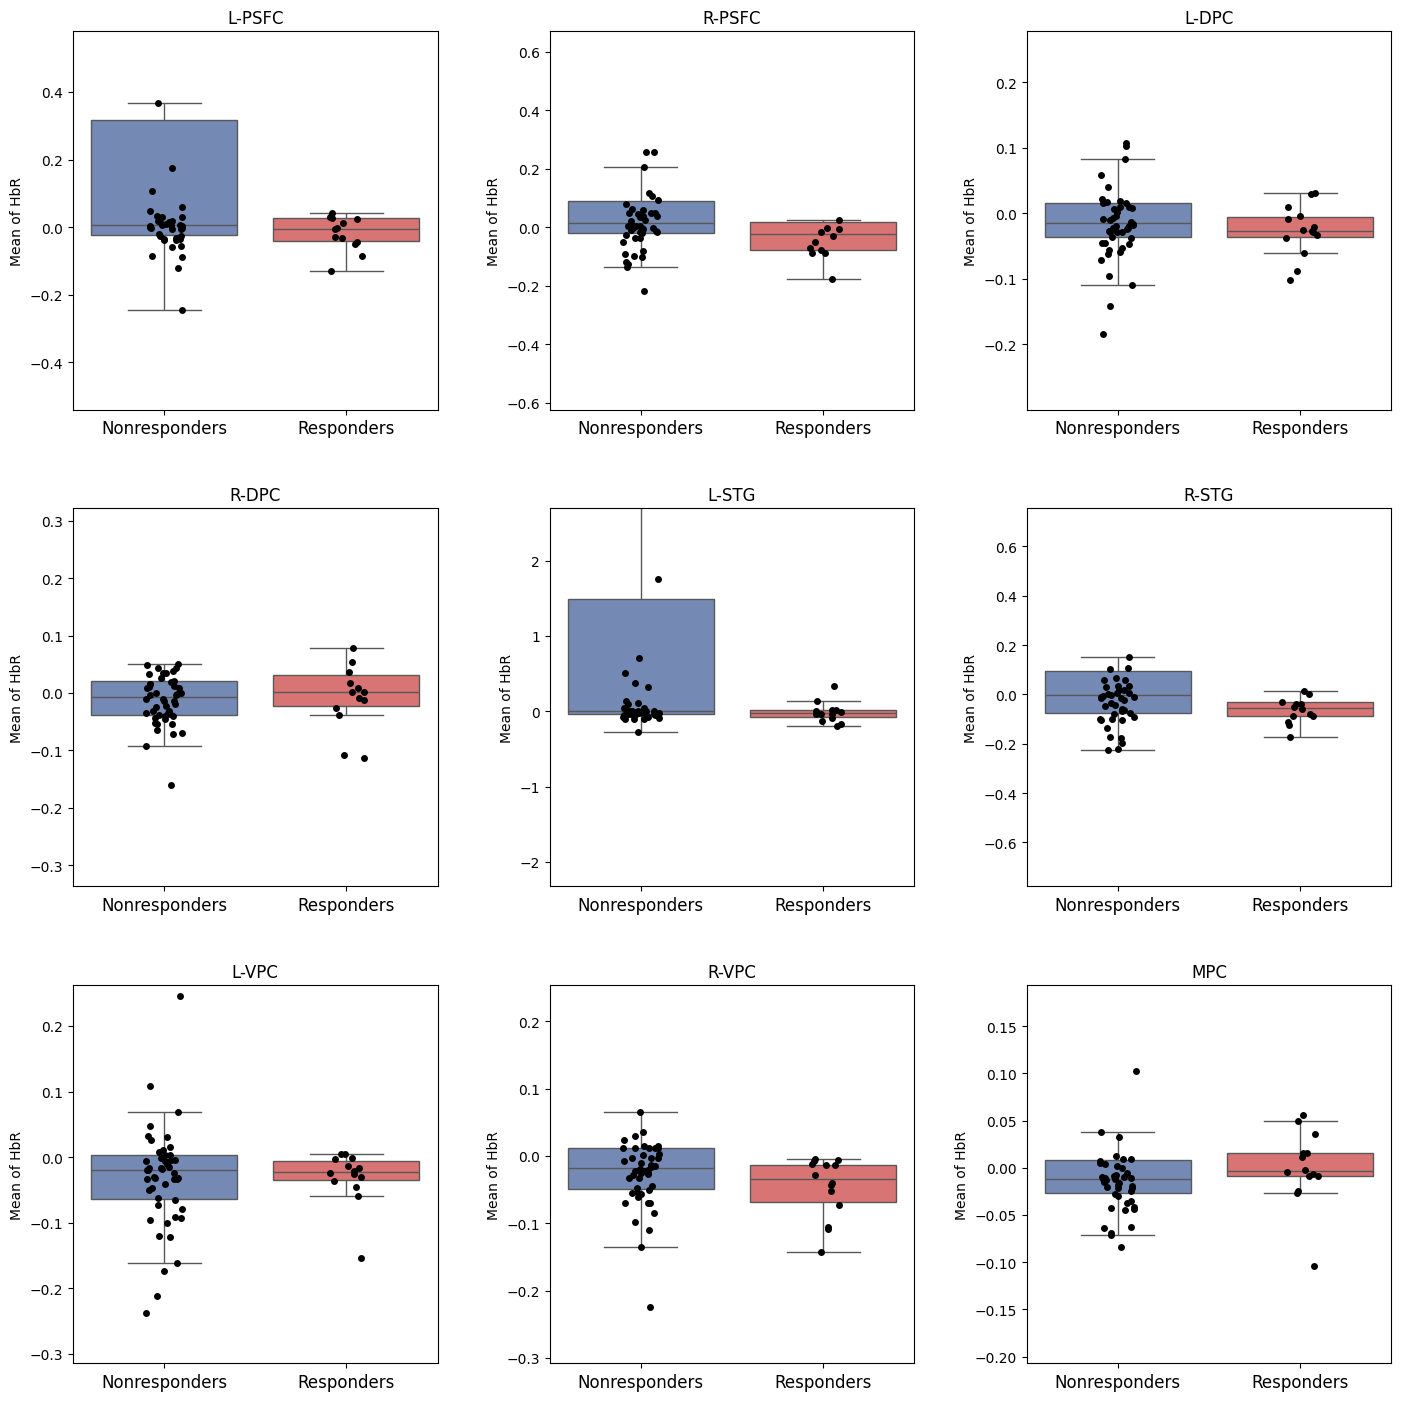

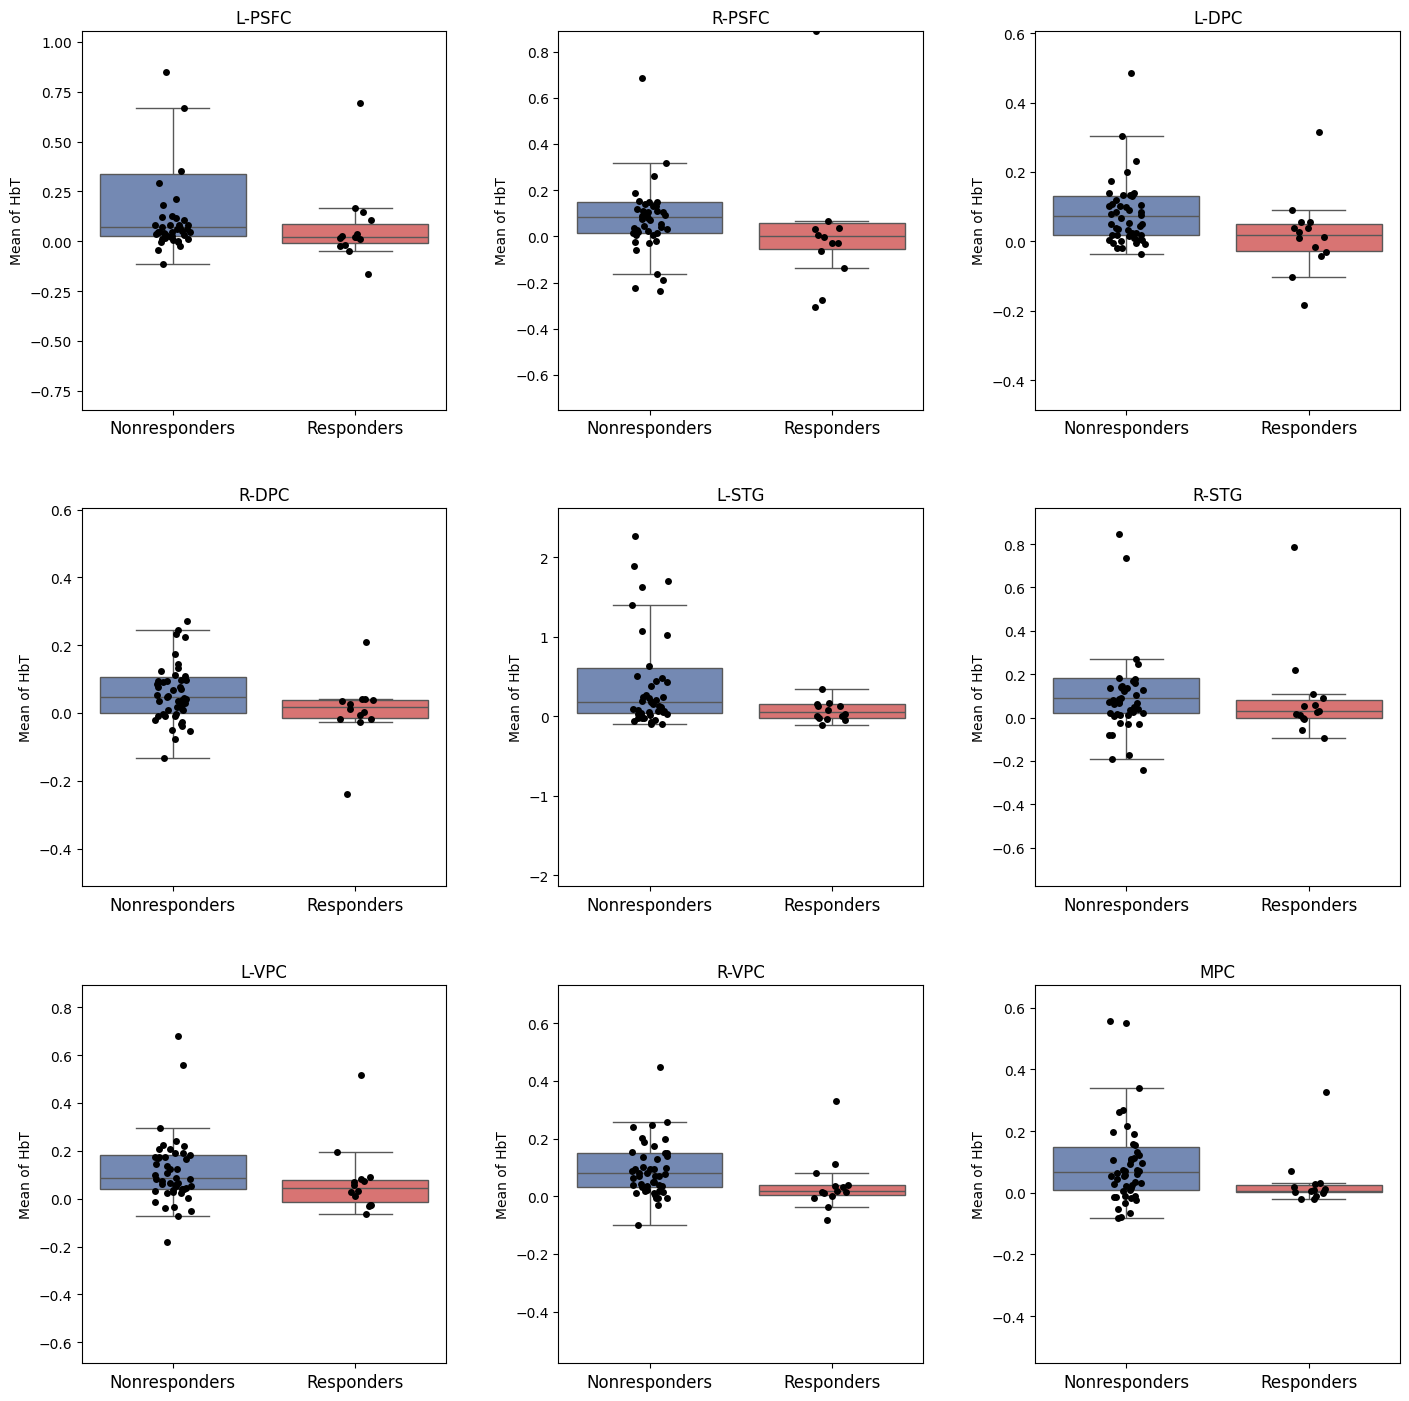

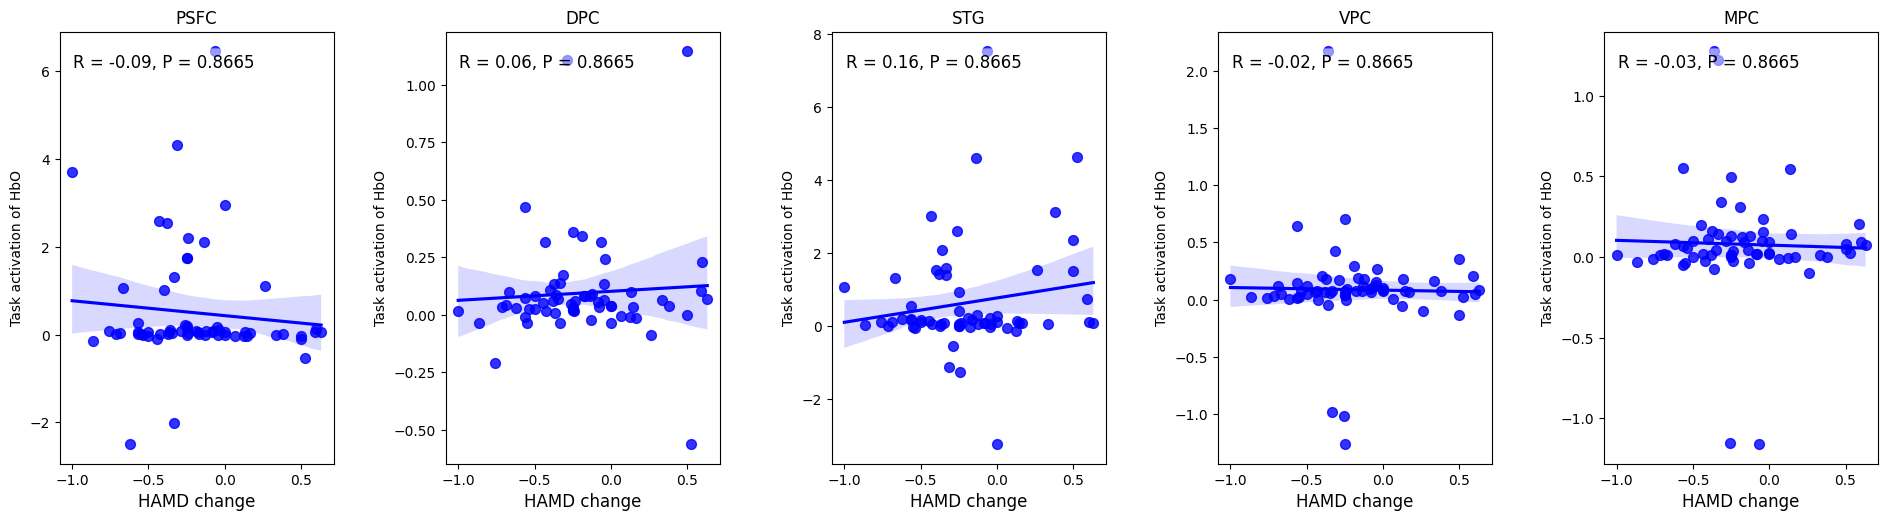

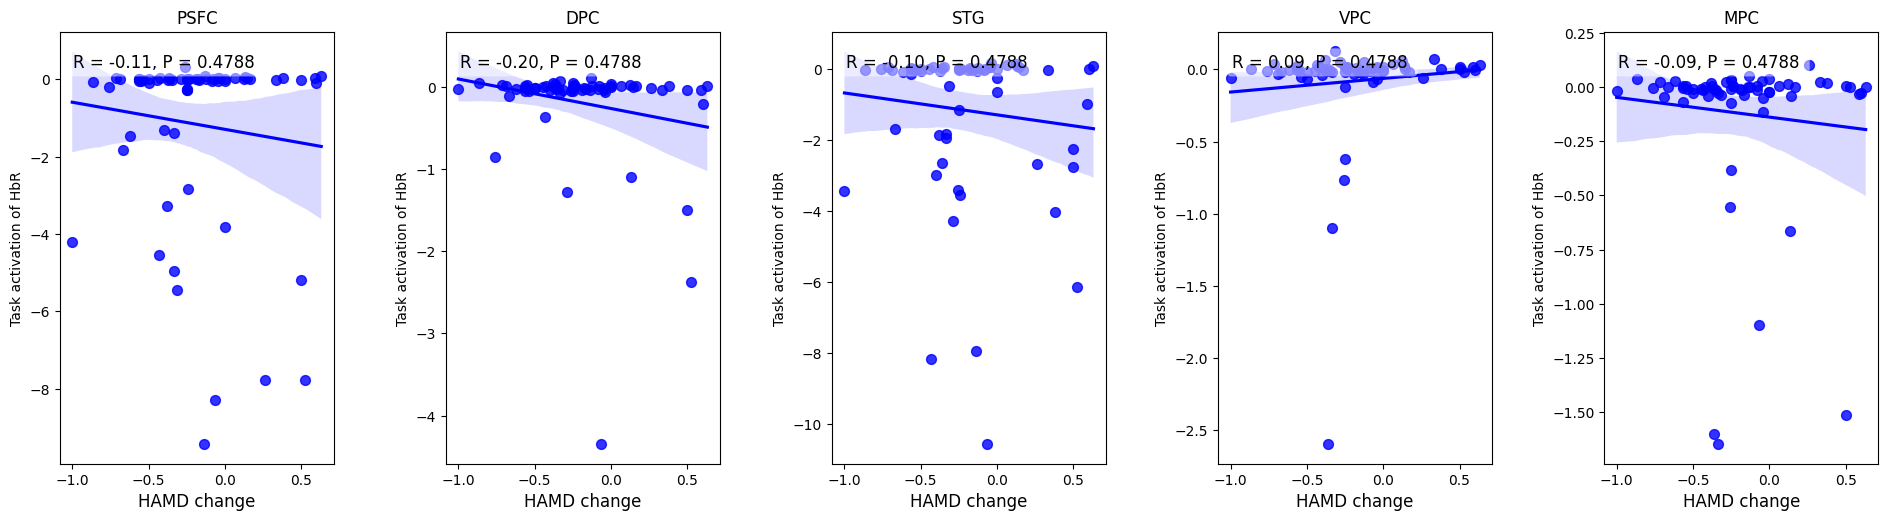

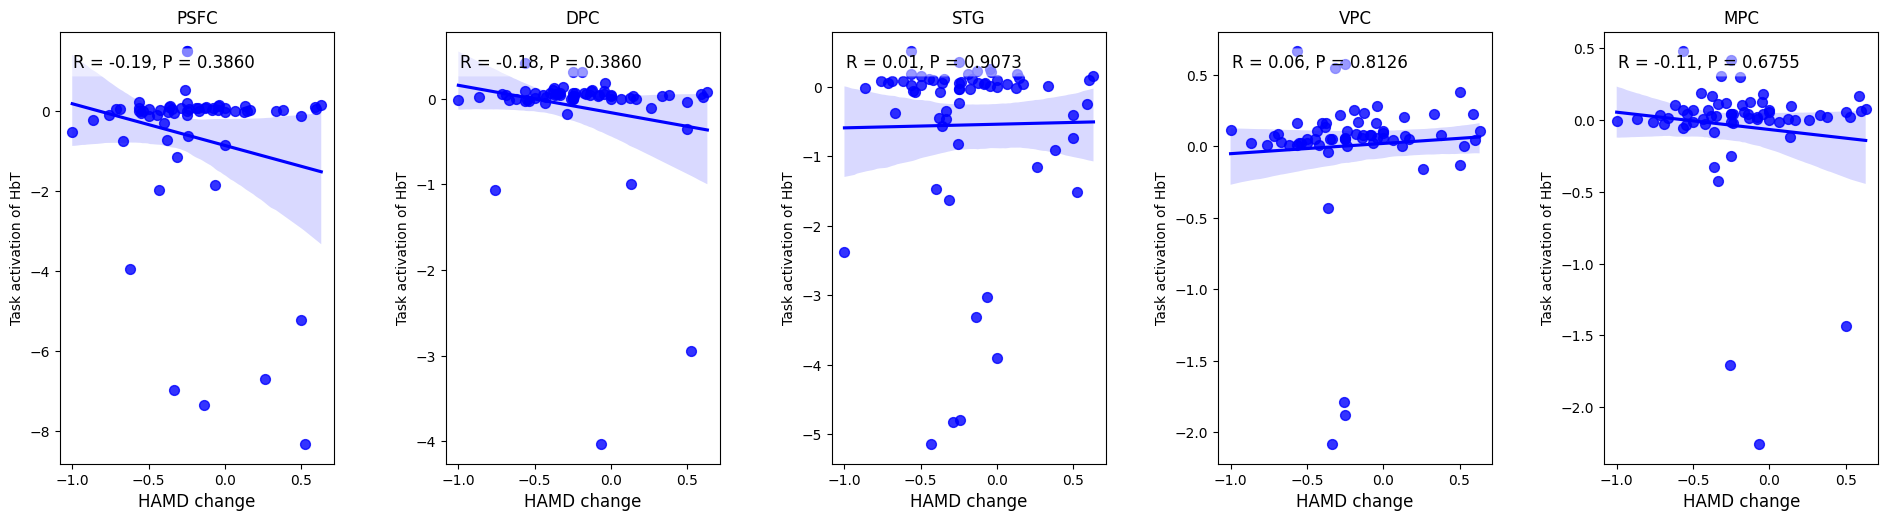

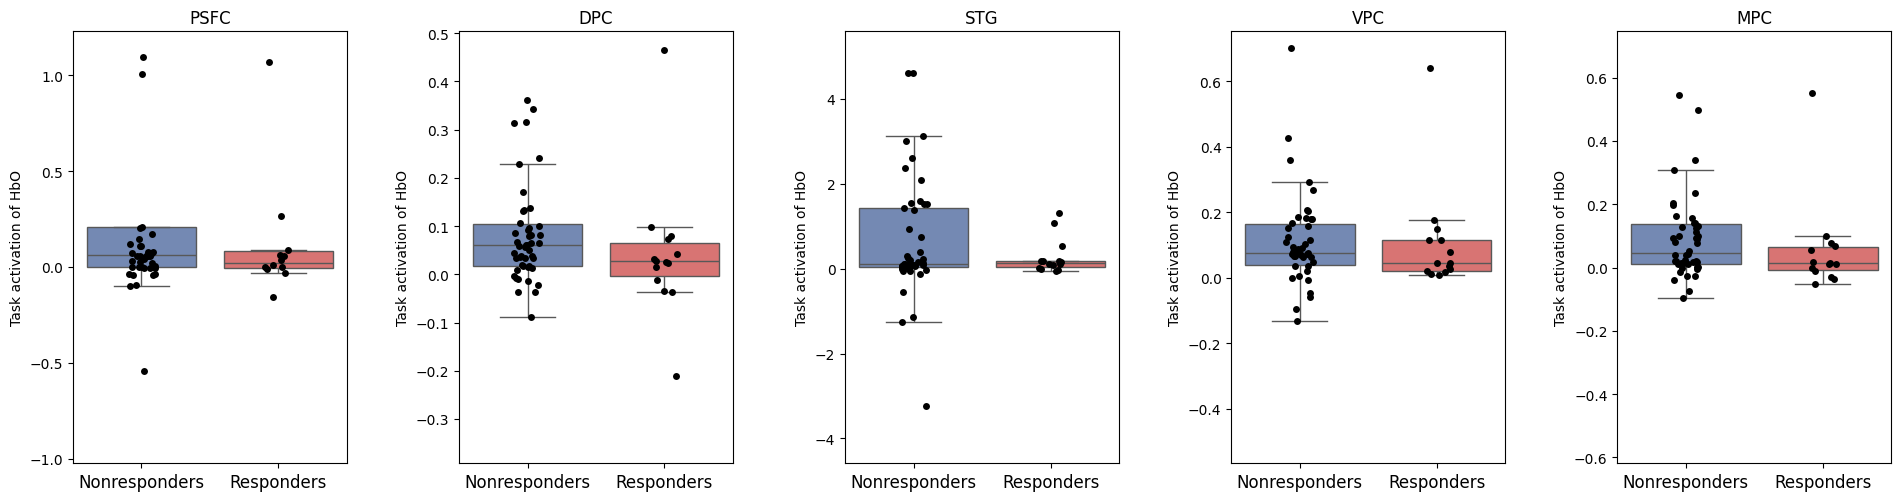

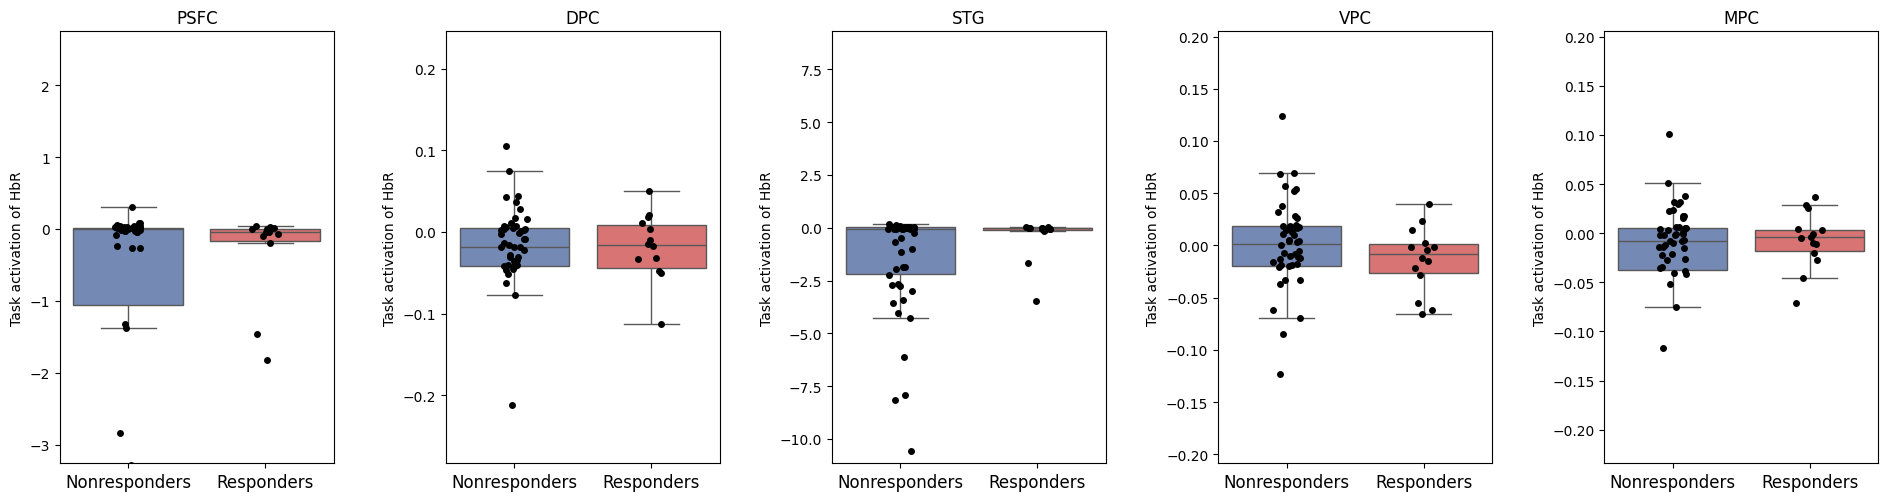

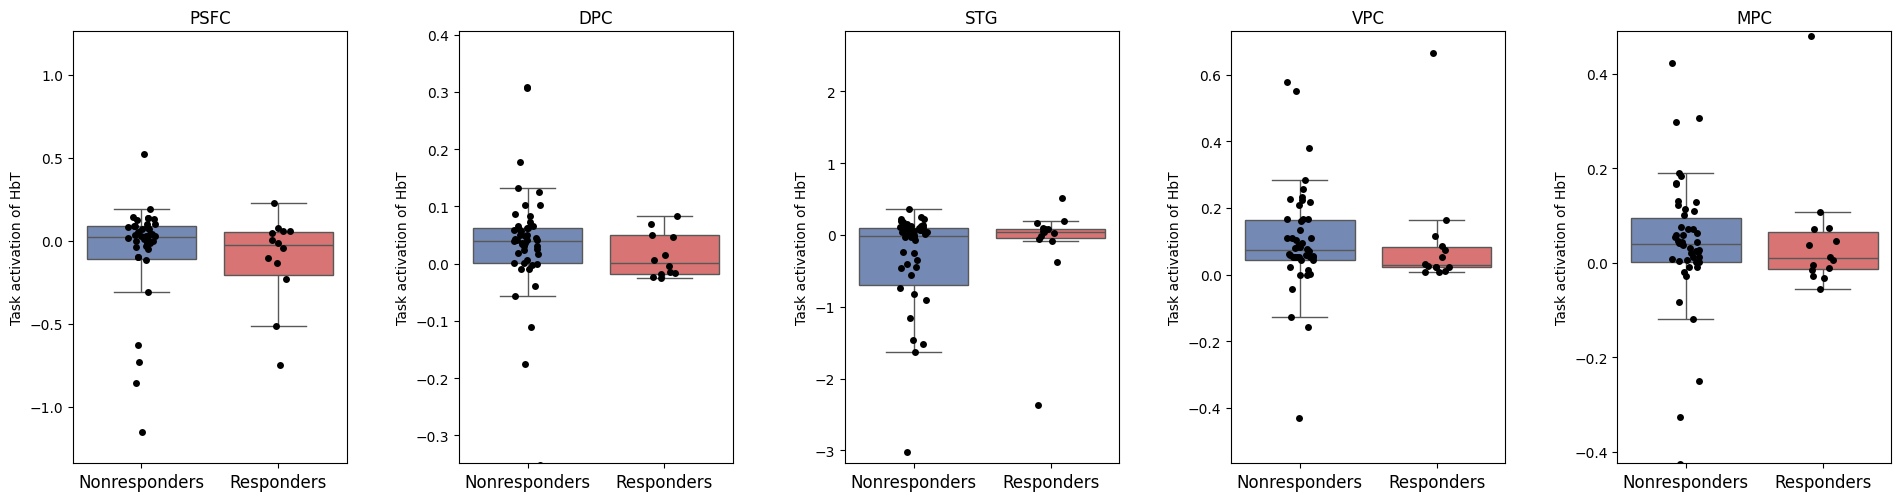

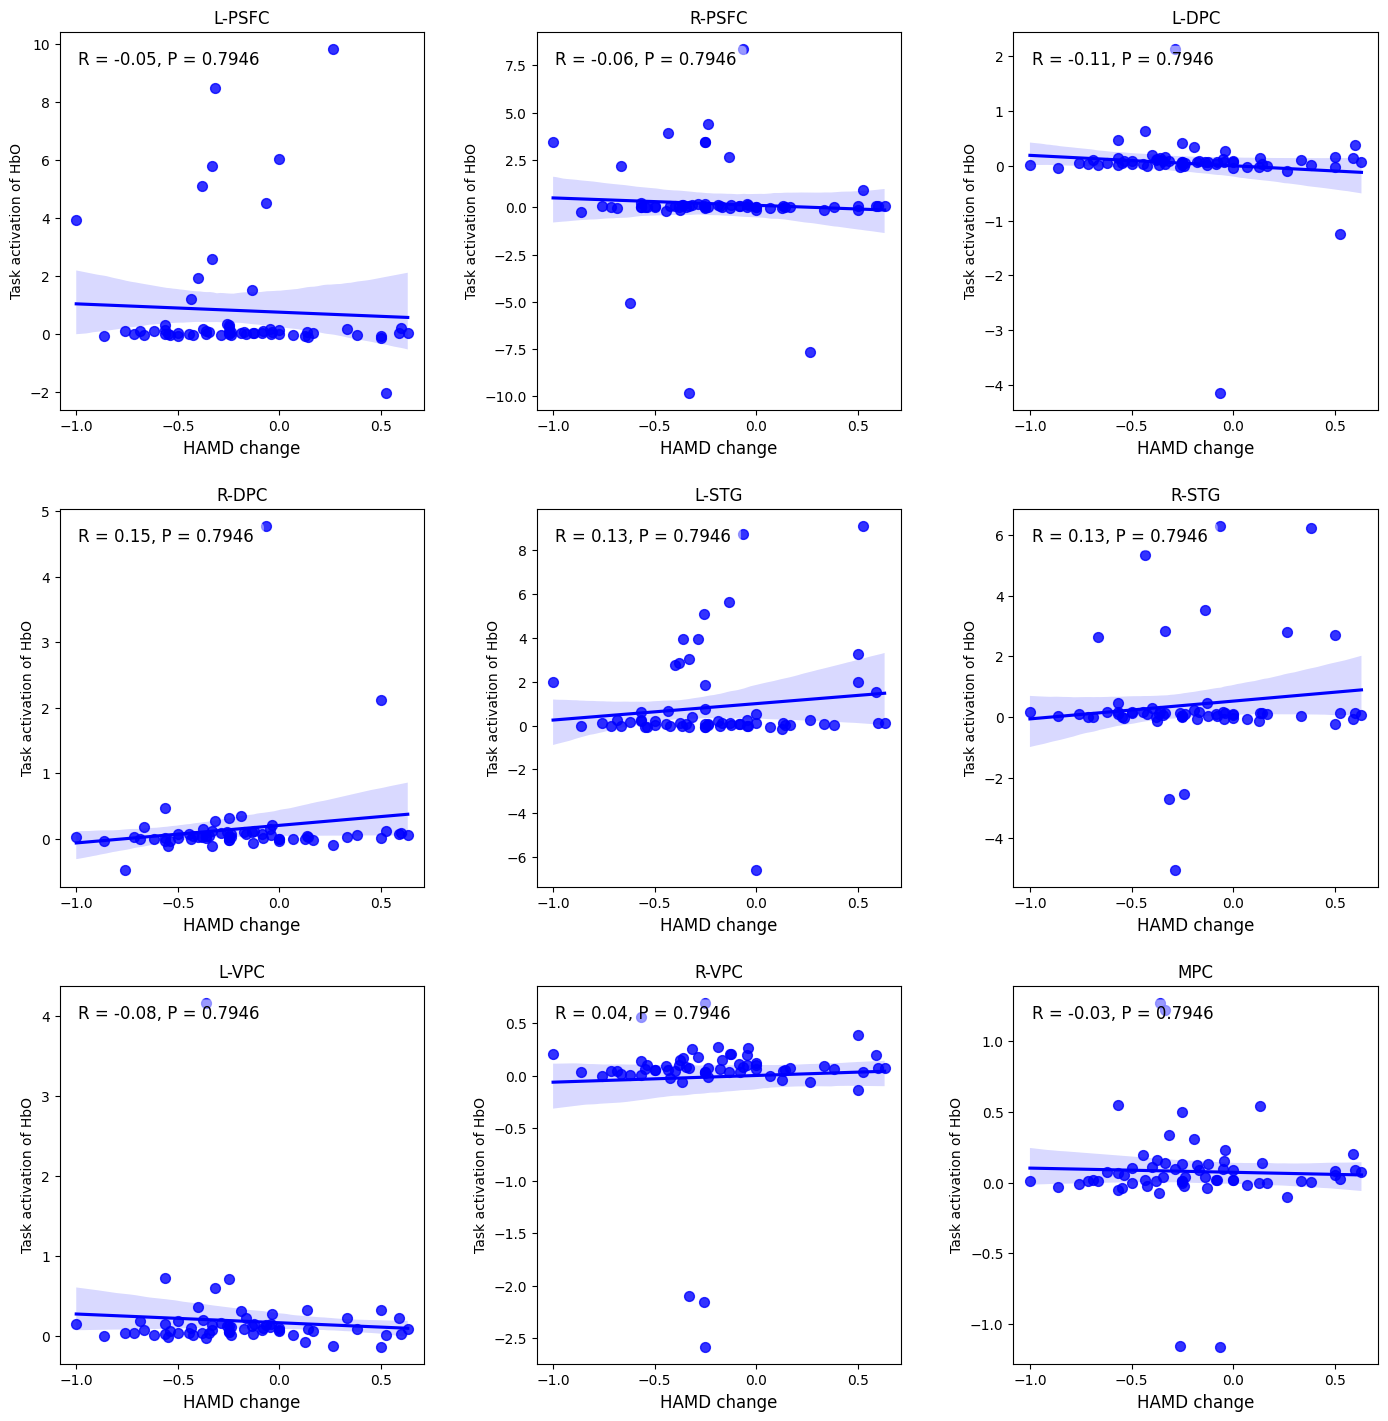

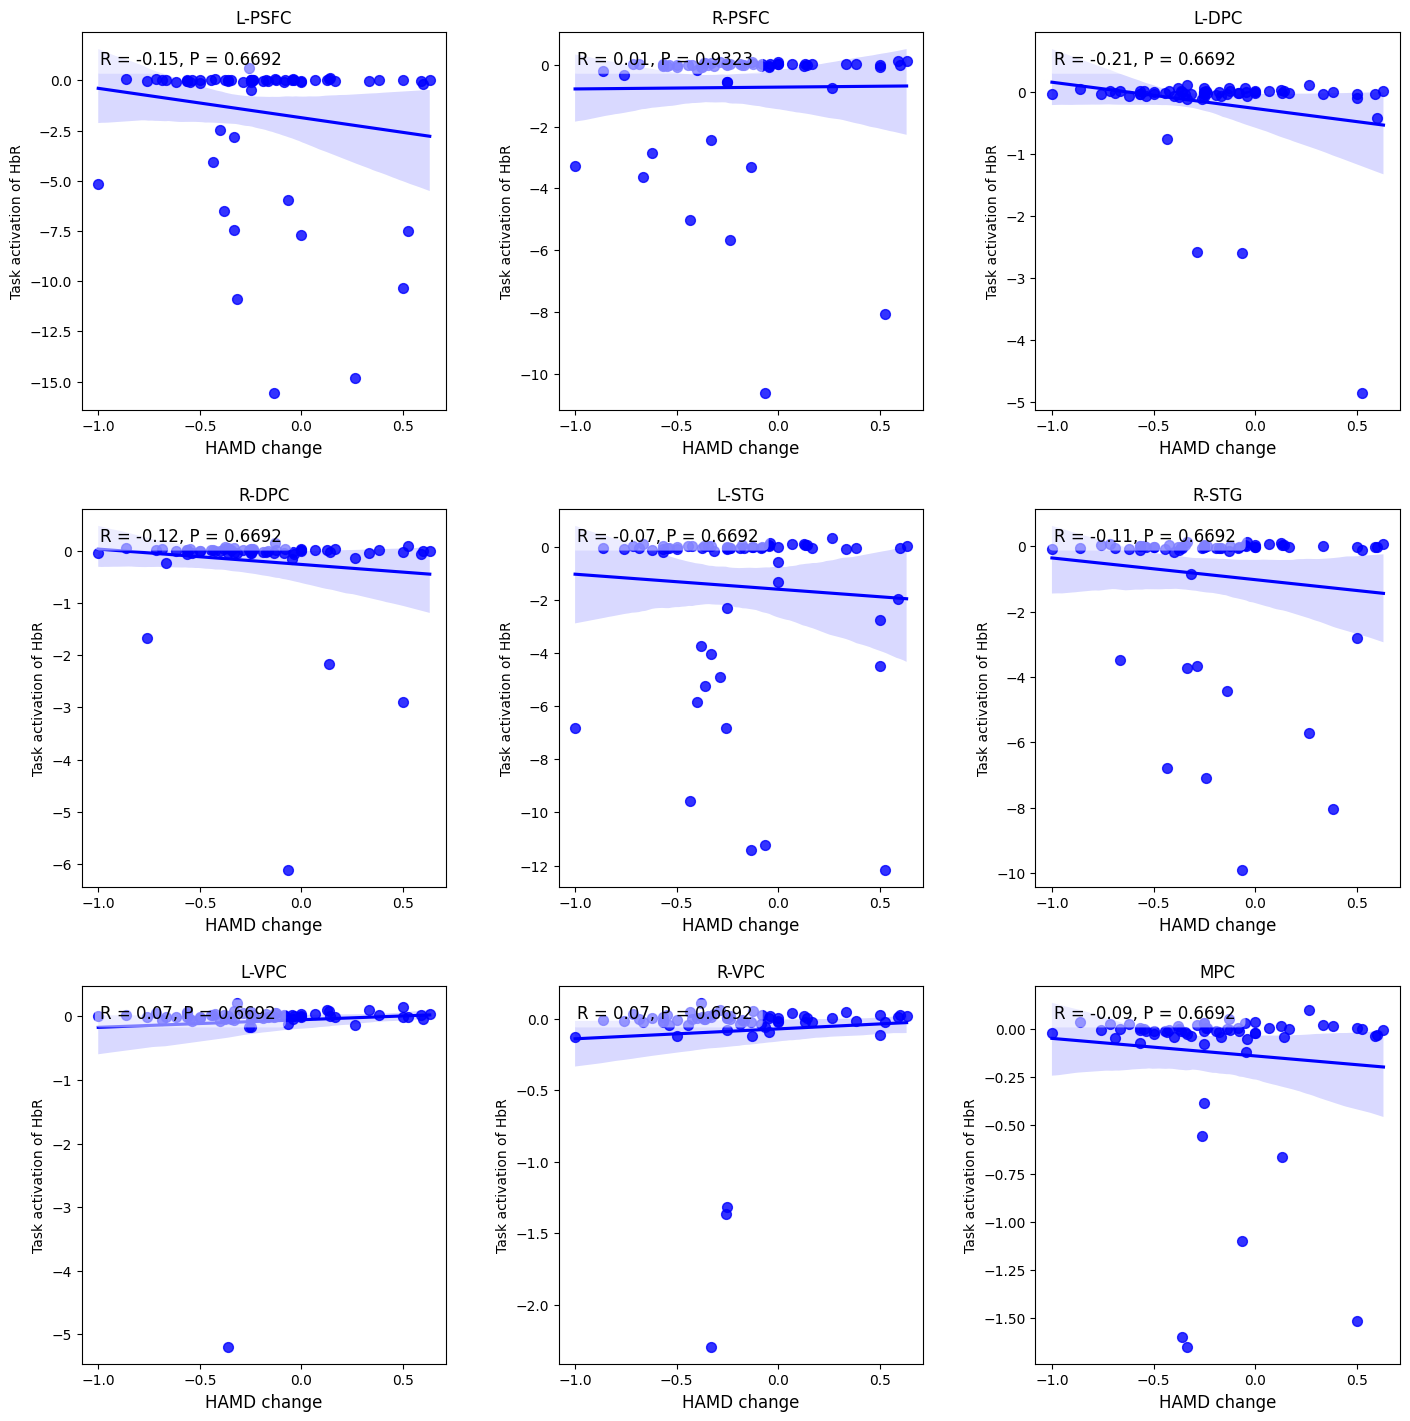

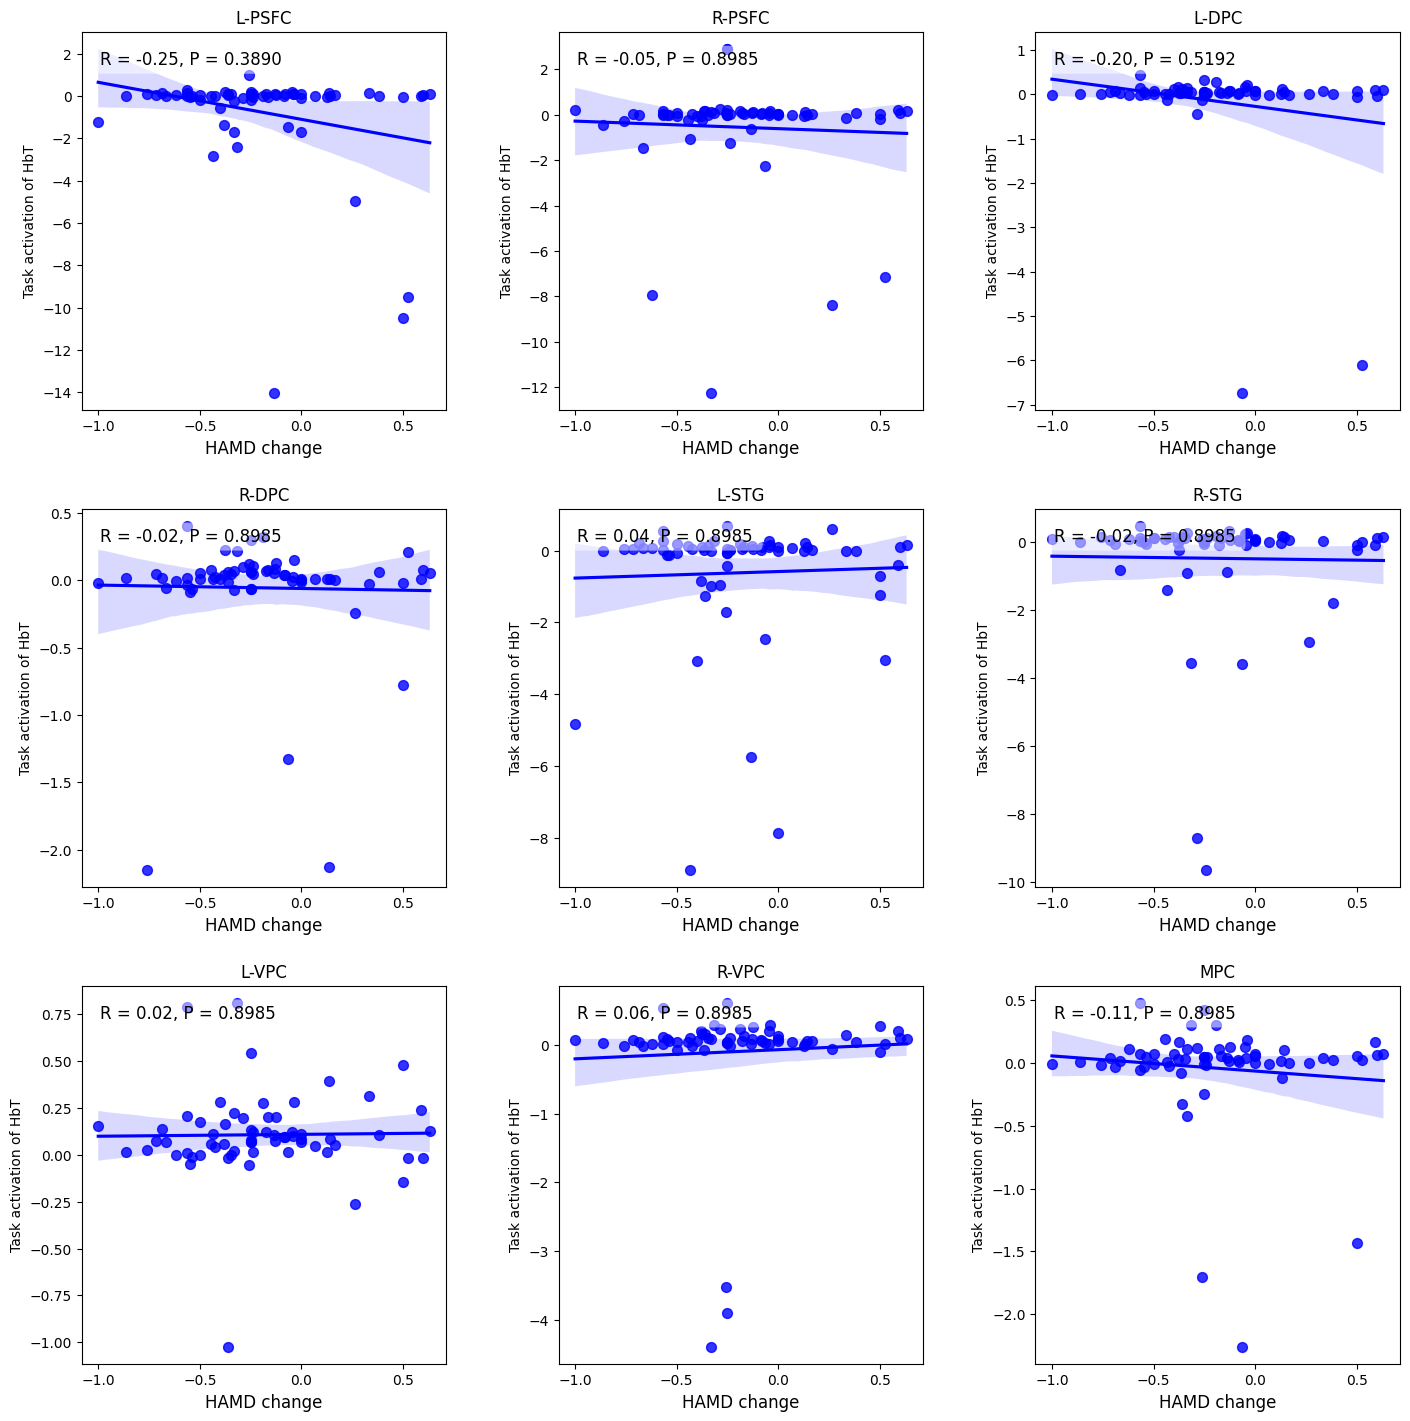

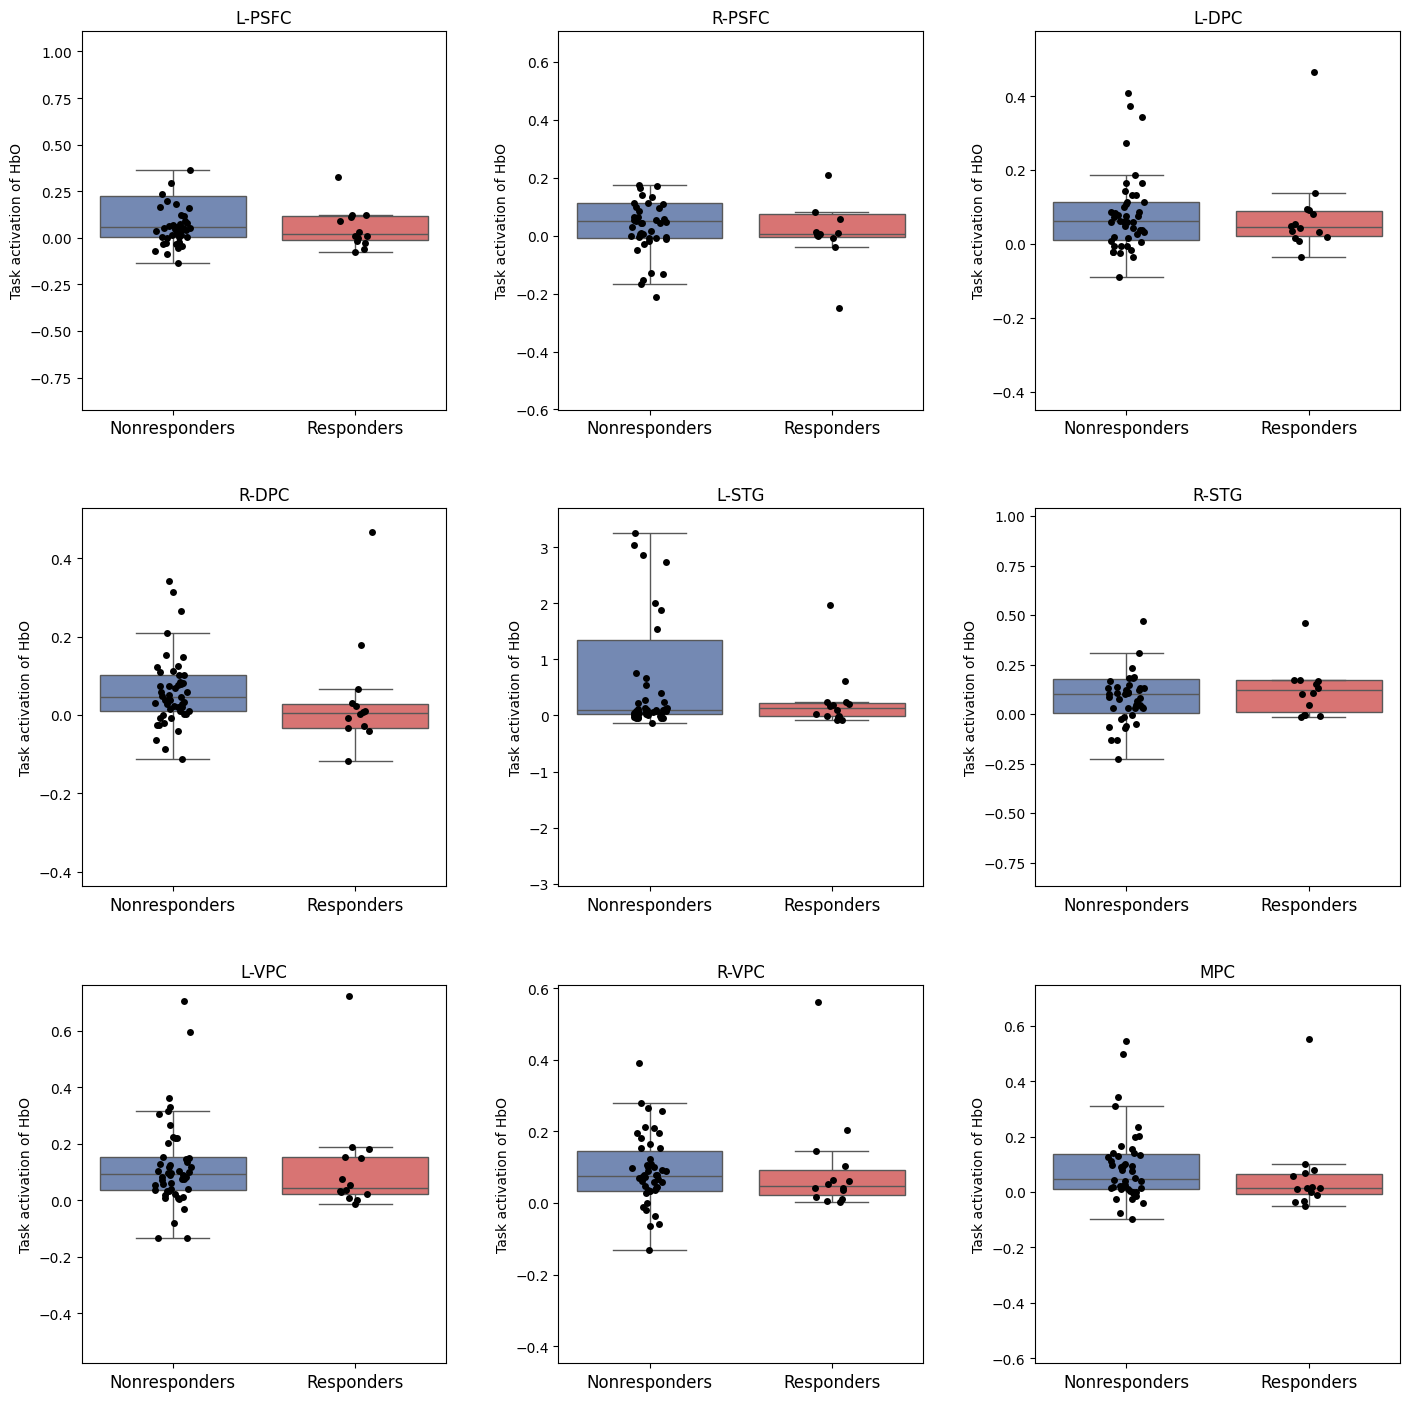

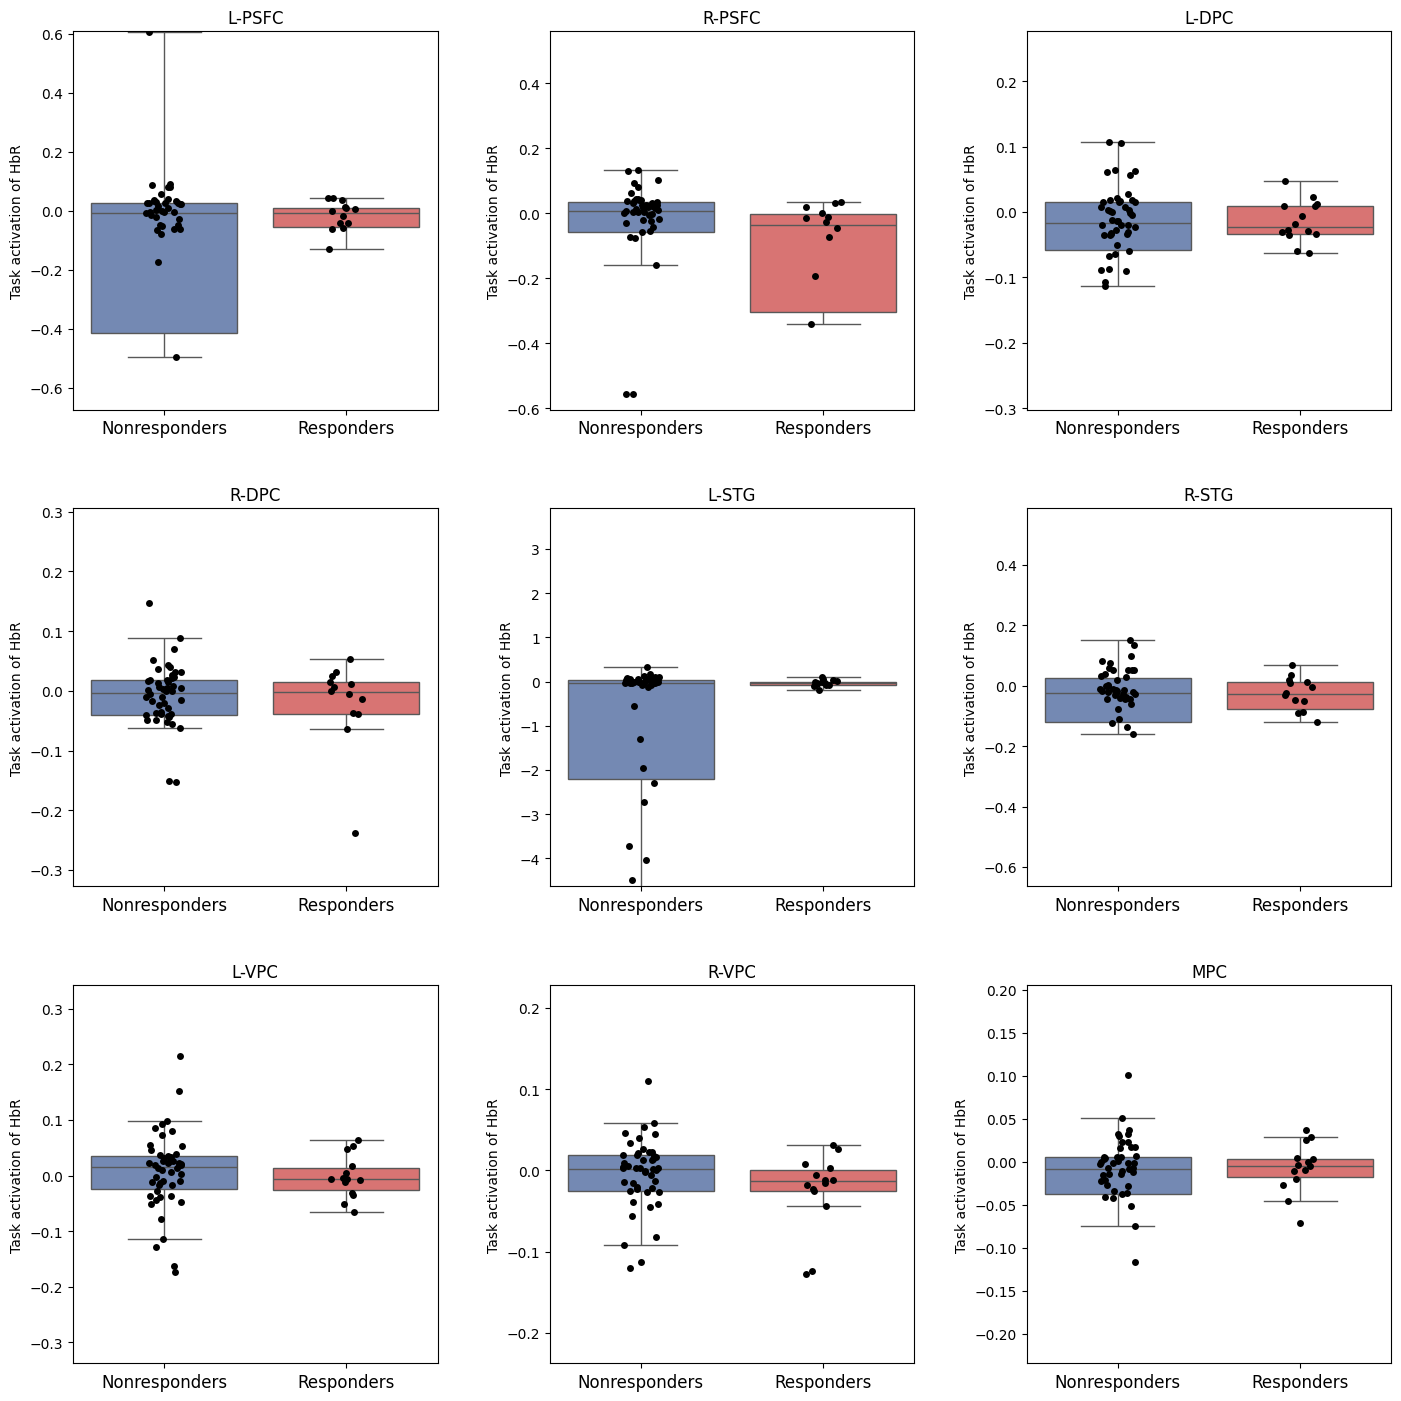

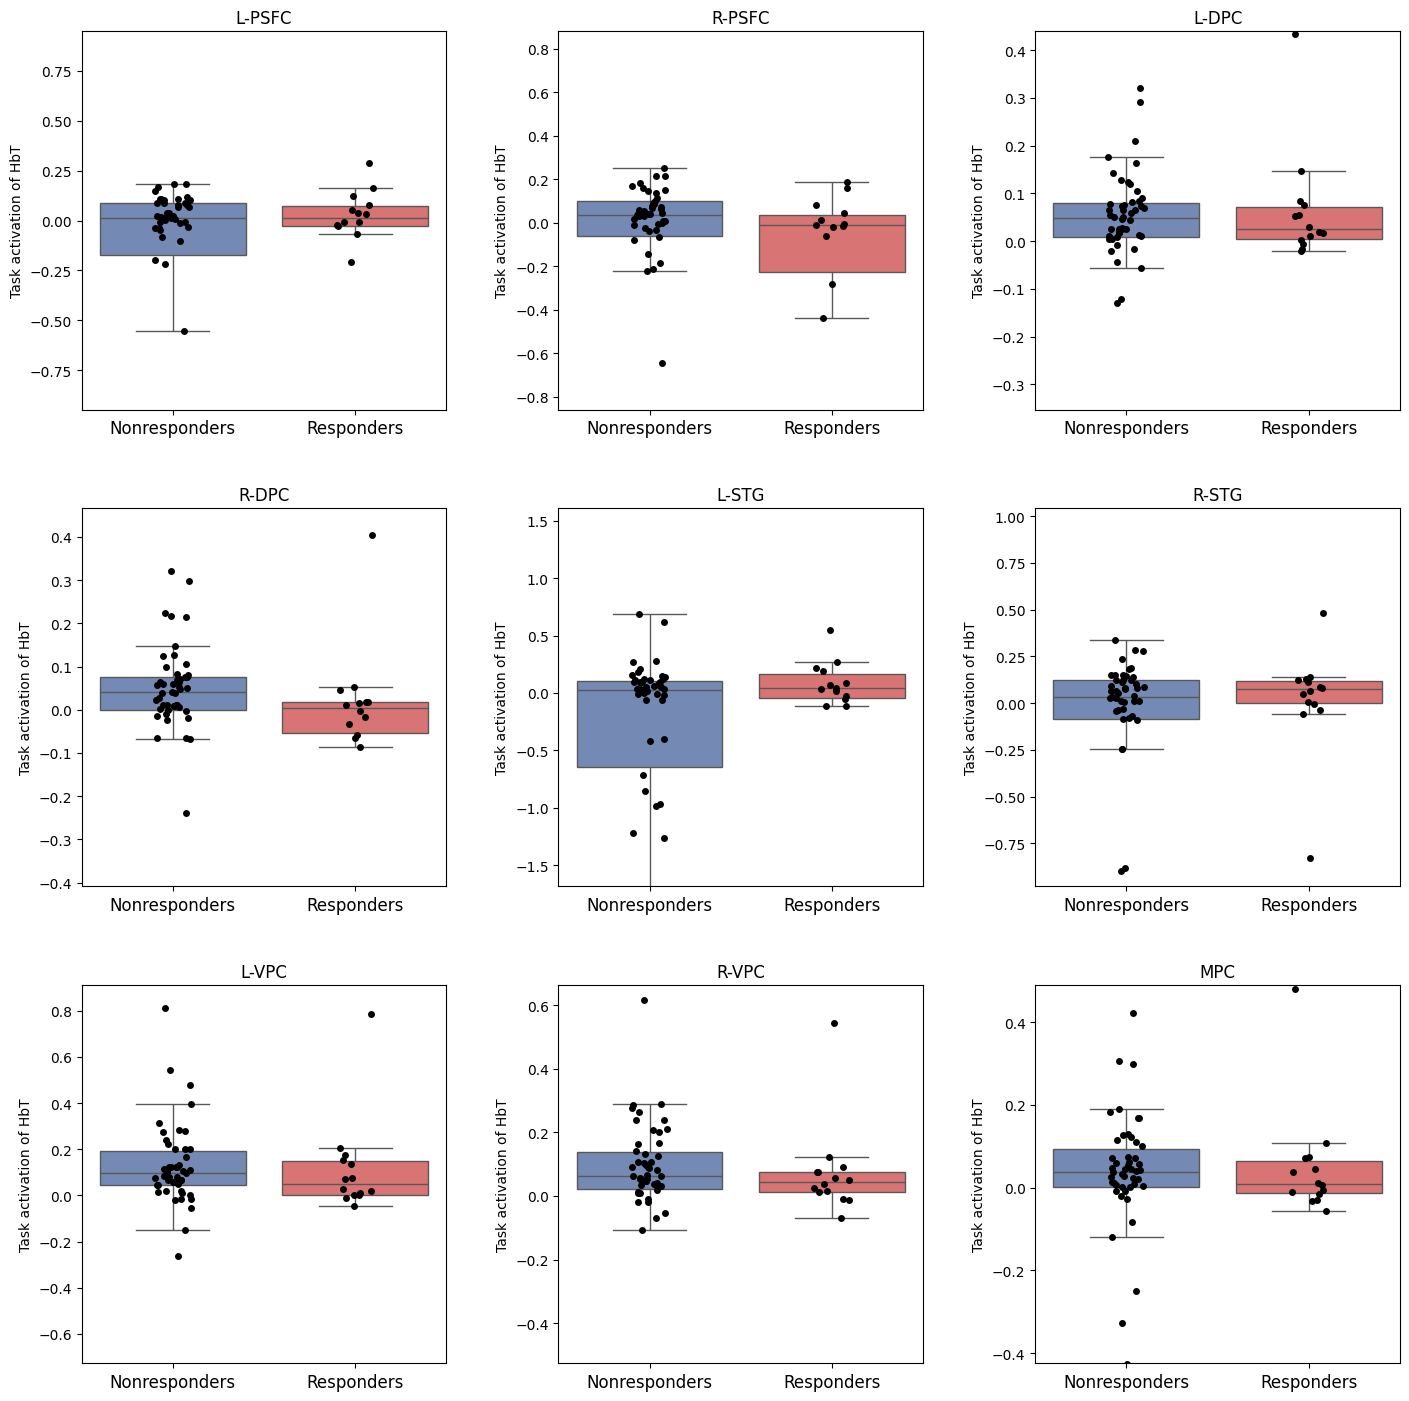

In [7]:


import matplotlib.pyplot as plt

from chord import Chord
# load 
import sys
import time

from sklearn.model_selection import cross_val_score,train_test_split
from datetime import date
import numpy as np
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import subprocess
import os 
from scipy.stats import ranksums
from scipy.stats import pearsonr
from scipy import stats
import seaborn as sns
from scipy.stats import mannwhitneyu
if sys.platform == 'darwin':
    print("Current system is macOS")
    main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
elif sys.platform == 'linux':
    print("Current system is Ubuntu")
    main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
else:
    print("Current system is neither macOS nor Ubuntu")
    
    
os.chdir(main_fold_path)


from utils.fnirs_utils import get_nine_region_data


    
DATA =  np.load('allData/prognosis_mix_hb/pretreatment_response/hb_data.npy')
LABEL =  np.load('allData/prognosis_mix_hb/pretreatment_response/label.npy')
data = DATA
label = LABEL
data = get_nine_region_data(data)

x = np.load('allData/prognosis_mix_hb/pretreatment_response/label_hamd.npy')
reduced_percentage = (x[:, 1] - x[:, 0]) / x[:, 0]

HbO = np.transpose(data[...,0::2],(0,2,1))
# HbO = individual_normalization(HbO)
print(f'HbO: {HbO.shape}')
HbR = np.transpose(data[...,1::2],(0,2,1))
HbT = HbO + HbR

def set_xlabel_of_ax(ax, label_name, font_size):
    if label_name == 'HAMD_change':
        ax.set_xlabel('HAMD change', fontsize=font_size)
        ax.set_xticks(np.arange(-1,1, 0.5))
        
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Nonresponders', 'Responders'], fontsize=font_size)
            
def get_five_regions_from_nine(data):
    res = np.zeros((data.shape[0], 5))
    res[:, 0] = (data[:, 0] + data[:, 1]) / 2
    res[:, 1] = (data[:, 2] + data[:, 3]) / 2
    res[:, 2] = (data[:, 4] + data[:, 5]) / 2
    res[:, 3] = (data[:, 6] + data[:, 7]) / 2
    res[:, 4] = data[:, 8]
    return res 

def plot_correlation_ax(axs, label_val, task_change_hb, label_name, region_num):
    
    all_p_value = []
    all_R = []
    all_whisker_low_high = []
    for i in range(task_change_hb.shape[-1]):
        if region_num=='five_regions': 
            ax = axs[i]
        else:
            ax = axs[i // 3, i % 3]
        region_task_change = task_change_hb[:, i]
            
        if label_name == 'HAMD_change':
            # Calculate correlation coefficient and p-value
            stat, p_value = pearsonr(label_val, region_task_change)
            
            # Create a new figure
            sns.regplot(x=label_val, y=region_task_change, ax=ax, color='blue', scatter_kws={'s': 50}, line_kws={'color': 'blue'})


        else: 
            
            responders = region_task_change[label_val == 1]
            nonresponders = region_task_change[label_val == 0]
            
            stat, p_value = mannwhitneyu(responders, nonresponders)
            # 绘制boxplot
            sns.boxplot(data=[nonresponders, responders], ax=ax, palette=["#6986be", "#e96362"],showfliers=False)

            # 绘制散点图
            sns.stripplot(data=[nonresponders, responders], ax=ax, color='black', jitter=0.1, size=5)
            data = np.concatenate([responders, nonresponders])
            q1, q3 = np.percentile(data, [25, 75])
            iqr = q3 - q1
            whisker_low = q1 - 5 * iqr
            whisker_high = q3 + 5 * iqr
            # 设置ylim基于须的范围
            ax.set_ylim(whisker_low, whisker_high)
            all_whisker_low_high.append((whisker_low, whisker_high))
            
        all_p_value.append(p_value)
        all_R.append(stat)
        
        set_xlabel_of_ax(ax, label_name, font_size=12)
        ax.set_ylabel(f"{feature_name} of {hb_type}")
        ax.set_title(region_name[i])
    
    fdr_correct_all_p_value = multipletests(all_p_value, method='fdr_bh')[1]
    for i in range(task_change_hb.shape[-1]):
        if region_num=='five_regions': 
            ax = axs[i]
        else:
            ax = axs[i // 3, i % 3]
        p_value = fdr_correct_all_p_value[i]
        R = all_R[i]
        
        if label_name == 'HAMD_change':
            ax.text(0.05, 0.95, f'R = {R:.2f}, P = {p_value:.4f} ',
                transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=0.5), fontsize=12)
        else:
            whisker_low, whisker_high = all_whisker_low_high[i]
            # 添加统计检验结果
                # Add statistical significance if p < 0.05
            if p_value < 0.05:
                # Determine the positions for the line and the asterisk
                max_val = whisker_high
                min_val = whisker_low
                mid_point = np.mean(ax.get_xticks())
                line_height = max_val *0.8

                # Draw a line and asterisk
                ax.plot([ax.get_xticks()[0], ax.get_xticks()[-1]], [line_height, line_height], color="black")
                ax.text(mid_point, line_height, f'*', ha='center', va='bottom', color='black', fontsize=12)
                
    
    for i in fdr_correct_all_p_value:
        if i < 0.05:
            return True
    return False

                
                    
                    
                    
                    

task_end_index = 700
task_start_index = 100
nine_region_name = ['L-PSFC', 'R-PSFC', 'L-DPC', 'R-DPC', 'L-STG', 'R-STG', 'L-VPC', 'R-VPC', 'MPC']
five_region_name = ['PSFC', 'DPC', 'STG', 'VPC', 'MPC']

dict_hb = {'HbO': HbO, 'HbR': HbR, 'HbT': HbT}

dict_label = {'HAMD_change': reduced_percentage, 'Responders': label}

dict_region = {'five_regions': five_region_name, 'nine_regions': nine_region_name}

feature_name_all = ['Task change', 'Mean', 'Task activation']

HB = HbT
hb_type = 'HbT'

region_num = 'nine_regions'

output_fold = 'FigureTable/regression'

res_of_dpc = []
res_of_dpc_name = []

res_of_psfc = []
res_of_psfc_name = []
for feature_name in feature_name_all:
    for region_num, region_name in dict_region.items():
        for label_name, label_val in dict_label.items():
            for hb_type, HB in dict_hb.items():
                task_change_hb = np.zeros((64, 1, 9))
                
                for i in range(task_change_hb.shape[-1]):
                    if feature_name == 'Task change': x = HB[:, task_end_index:, i].mean(axis=1) - HB[:, :task_start_index, i].mean(axis=1)
                    if feature_name == 'Mean': x = HB[:, :, i].mean(axis=1) 
                    if feature_name == 'Task activation': x = HB[:, task_start_index:task_end_index, i].mean(axis=1) - HB[:, :task_start_index, i].mean(axis=1) - HB[:, task_end_index:, i].mean(axis=1)
                    
                    x = x[:, np.newaxis]
                    task_change_hb[:, :, i] = x

                task_change_hb = task_change_hb.squeeze()

                    
                    
                if region_num=='five_regions': 
                    task_change_hb = get_five_regions_from_nine(task_change_hb)
                    fig, axs = plt.subplots(1, 5, figsize=(20, 6))
                else:
                    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
                
                if region_num == 'five_regions' and feature_name == 'Task change' and hb_type == 'HbT':
                    if label_name == 'HAMD_change':
                        res_of_dpc.append(task_change_hb[:, 1])
                        res_of_dpc_name.append(f'{feature_name}_{hb_type}_{region_num}_{label_name}')
                    if label_name == 'Responders':
                        res_of_psfc.append(task_change_hb[:, 0])
                        res_of_psfc_name.append(f'{feature_name}_{hb_type}_{region_num}_{label_name}')
                if region_num == 'nine_regions' and feature_name == 'Task change' and hb_type == 'HbT':

                    if label_name == 'HAMD_change':
                        res_of_dpc.append(task_change_hb[:, 2])                    
                        res_of_dpc.append(task_change_hb[:, 3])                    
                        res_of_dpc_name.append(f'{feature_name}_{hb_type}_{region_num}_{label_name}_left')
                        res_of_dpc_name.append(f'{feature_name}_{hb_type}_{region_num}_{label_name}_right')
                    if label_name == 'Responders':
                        res_of_psfc.append(task_change_hb[:, 0])                    
                        res_of_psfc.append(task_change_hb[:, 1])                    
                        res_of_psfc_name.append(f'{feature_name}_{hb_type}_{region_num}_{label_name}_left')
                        res_of_psfc_name.append(f'{feature_name}_{hb_type}_{region_num}_{label_name}_right')
                    
                fig.tight_layout(pad=5.0)
                signifance_flag = plot_correlation_ax(axs, label_val, task_change_hb, label_name, region_num)
                # for i in range(task_change_hb.shape[-1]):
                #     if region_num=='five_regions': 
                #         ax = axs[i]
                #     else:
                #         ax = axs[i // 3, i % 3]
                #     region_task_change = task_change_hb[:, i]
                    
                    
                #     set_xlabel_of_ax(ax, label_name, font_size=12)
                #     ax.set_ylabel(f"{feature_name} of {hb_type}")
                #     ax.set_title(region_name[i])
            

                output_fold_final = output_fold + '/all/' + f'{label_name}/{region_num}'
                if not os.path.exists(output_fold_final):
                        os.makedirs(output_fold_final)
                plt.savefig(output_fold_final + f'/{feature_name}_{hb_type}_{region_num}.png')
                
                if signifance_flag:
                    output_fold_final = output_fold + '/significance/' + f'{label_name}/{region_num}'
                    if not os.path.exists(output_fold_final):
                            os.makedirs(output_fold_final)
                    plt.savefig(output_fold_final + f'/{feature_name}_{hb_type}_{region_num}.png')


[-2.00138003e-02 -4.25787315e-01 -1.70444516e+00 -2.50371378e-01
  1.68695016e-01  5.75337558e-02 -1.18314636e-01  2.03689870e-02
  4.14658531e-02  2.98220785e-01  1.21349055e-01  4.64694977e-02
  2.49849307e-02 -2.25677428e+00  7.16337115e-02  3.20049971e-02
  3.57537142e-04  1.89713675e-01  7.16637202e-02  2.89061898e-03
  1.21822573e-02 -3.26876108e-01  6.03448021e-03  1.14152419e-01
  7.94991412e-03 -1.48702105e-02 -1.06126563e-02  5.50801679e-02
 -2.77845432e-02  4.22467738e-01  3.99382622e-02  1.14998432e-02
  4.38056386e-02  4.38056386e-02  2.28063439e-02  6.69690265e-03
 -8.27966841e-02  1.29870812e-01 -2.88681730e-02 -3.25864349e-02
  1.83116709e-01  4.79081848e-01  5.85874538e-02  1.55529094e-03
  1.26765562e-02  1.07613982e-01 -9.31796506e-03  3.75464988e-02
 -5.58618628e-02  2.75922310e-02  3.78736463e-02  7.47740804e-02
  1.67357681e-01  6.30043194e-02  1.27601472e-01  7.37287376e-02
  4.58915679e-02  1.09368065e-01  1.00433726e-01 -1.43591511e+00
 -5.48737383e-03  7.15344

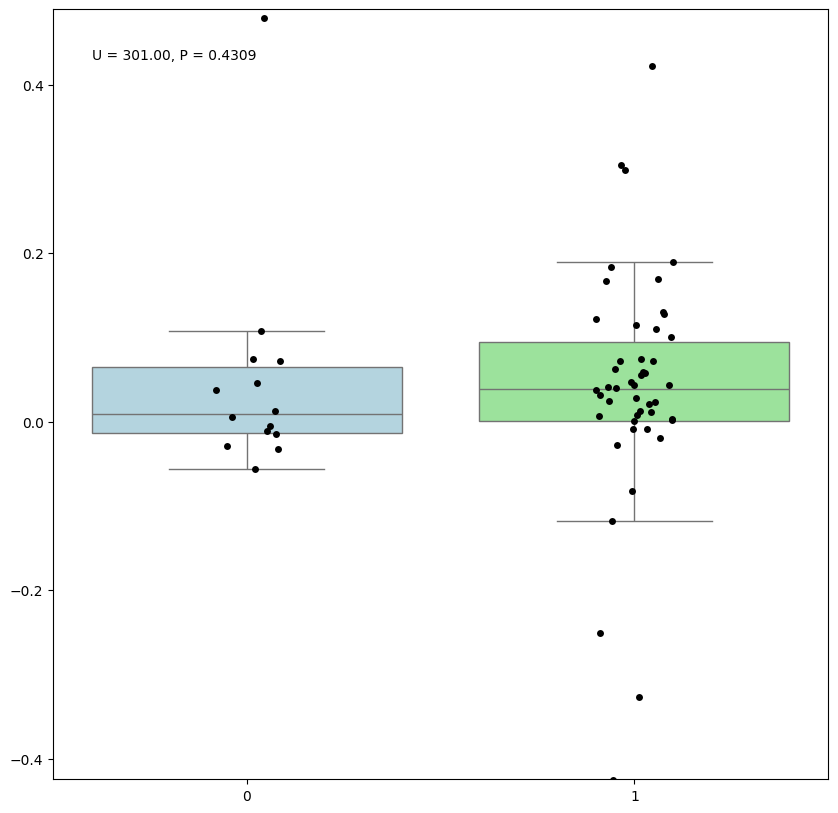

In [95]:
def plot_correlation_ax(ax, label_val, region_task_change, label_name='HAMD_change'):
    
    if label_name == 'HAMD_change':
        # Calculate correlation coefficient and p-value
        correlation_coefficient, p_value = pearsonr(label_val, region_task_change)
        
        # Create a new figure
        sns.regplot(x=label_val, y=region_task_change, ax=ax, color='blue', scatter_kws={'s': 50}, line_kws={'color': 'blue'})
        
        ax.text(0.05, 0.95, f'R = {correlation_coefficient:.2f}, P = {p_value:.4f} ',
            transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=0.5), fontsize=12)
    else: 
        
        responders = region_task_change[label_val == 1]
        nonresponders = region_task_change[label_val == 0]
        
        u_stat, p_value = mannwhitneyu(responders, nonresponders)
        
        # 绘制boxplot
        sns.boxplot(data=[responders, nonresponders], ax=ax, palette=["lightblue", "lightgreen"],showfliers=False)

        # 绘制散点图
        sns.stripplot(data=[responders, nonresponders], ax=ax, color='black', jitter=0.1, size=5)

        # 添加统计检验结果
        ax.text(0.05, 0.95, f'U = {u_stat:.2f}, P = {p_value:.4f}', 
                transform=ax.transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=0.5))
        # ax.set_ylim(-1,1)
        # ax.set_yticks(np.arange(-1,1.5, 0.5)) 
        # 计算IQR，并确定须的范围
        data = np.concatenate([responders, nonresponders])
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        whisker_low = q1 - 5 * iqr
        whisker_high = q3 + 5 * iqr
        # 设置ylim基于须的范围
        ax.set_ylim(whisker_low, whisker_high)
    return p_value

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
print(region_task_change)
print(label_val)
p_value = plot_correlation_ax(ax, label_val, region_task_change, label_name)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3, 64)


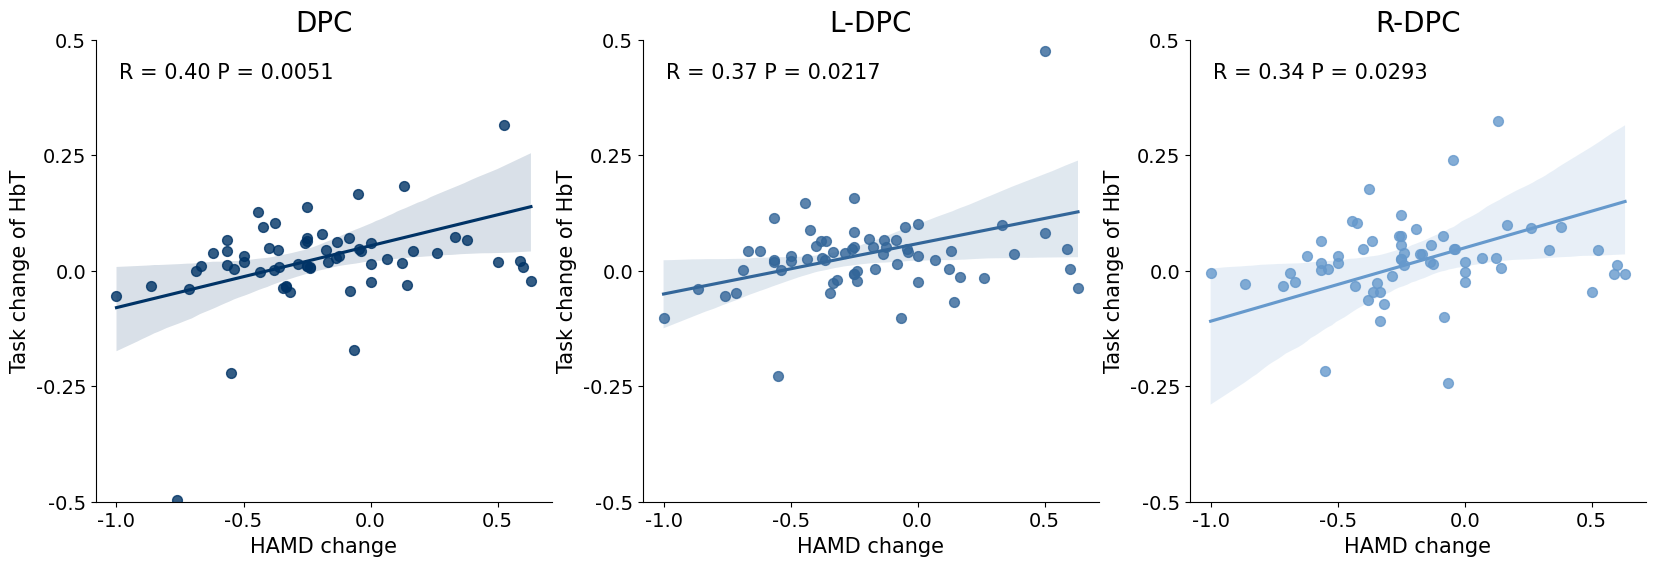

In [7]:

def set_xlabel_of_ax(ax, label_name, font_size):
    if label_name == 'HAMD_change':
        ax.set_xlabel('HAMD change', fontsize=font_size)
        ticks = np.arange(-1,1, 0.5)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{tick}" for tick in ticks], fontsize=14)  # Setting font size here
        
        
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Nonresponders', 'Responders'], fontsize=font_size)
        
np_res_of_dpc = np.array(res_of_dpc)
print(np_res_of_dpc.shape)
num_fig = np_res_of_dpc.shape[0]
fig, axs = plt.subplots(1, num_fig, figsize=(20, 6))
label_name = 'HAMD_change'
color_dark_to_light = ['#003366', '#336699', '#6699CC']

fdr_corrected_p_value = [0.0051, 0.0217, 0.0293]
            
for i in range(num_fig):
    ax = axs[i]
    region_task_change = np_res_of_dpc[i]
    label_val = reduced_percentage
    # Calculate correlation coefficient and p-value
    correlation_coefficient, p_value = pearsonr(label_val, region_task_change)
    p_value = fdr_corrected_p_value[i]
    # Fit a line to the data
    fit_line = np.polyfit(label_val, region_task_change, 1)

    # Evaluate the fit line at each data point
    fit_line_values = np.polyval(fit_line, label_val)

    # Create a new figure
    sns.regplot(x=label_val, y=region_task_change, ax=ax, color=color_dark_to_light[i], scatter_kws={'s': 50}, line_kws={'color': color_dark_to_light[i]})
        # Annotation for statistical significance
    significance_text = 'Significant' if p_value < 0.05 else 'Not significant'
    ax.text(0.05, 0.95, f'R = {correlation_coefficient:.2f} P = {p_value:.4f} ',
            transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=0.5), fontsize=15)

    # Showing only left and bottom spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    set_xlabel_of_ax(ax, label_name, font_size=15)

    ax.set_ylabel(f"Task change of {hb_type}", fontsize=15)
    ax.set_title(['DPC', 'L-DPC', 'R-DPC'][i], fontsize=20)
    if ax == axs[0]:
        ax.set_ylim(-0.5, 0.5)
        ticks = np.arange(-0.5, 0.6, 0.25)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{tick}" for tick in ticks], fontsize=14)  # Setting font size here
    else:
        ax.set_ylim(-0.5, 0.5)
        ticks = np.arange(-0.5, 0.6, 0.25)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{tick}" for tick in ticks], fontsize=14)  # Setting font size here

    ax.legend(frameon=False, fontsize=12)
    

    # Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3, 64)


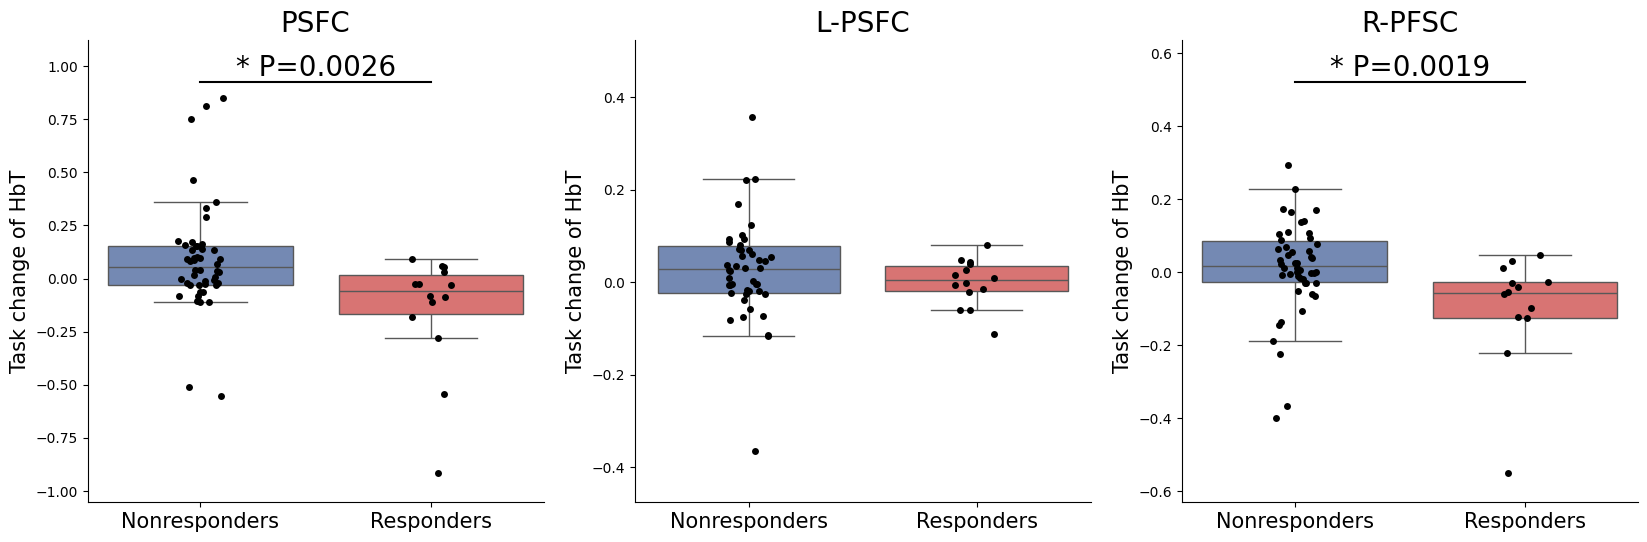

In [123]:
np_res_of_psfc = np.array(res_of_psfc)
print(np_res_of_psfc.shape)
num_fig = np_res_of_psfc.shape[0]
fig, axs = plt.subplots(1, num_fig, figsize=(20, 6))
label_name = 'Responders'
color_dark_to_light = ['#003366', '#336699', '#6699CC']


            
for i in range(num_fig):
    ax = axs[i]
    region_task_change = np_res_of_psfc[i]
    label_val = label
    # Calculate correlation coefficient and p-value
    responders = region_task_change[label_val == 1]
    nonresponders = region_task_change[label_val == 0]
    
    u_stat, p_value = mannwhitneyu(responders, nonresponders)
    
    # 绘制boxplot
    sns.boxplot(data=[nonresponders, responders], ax=ax, palette=["#6986be", "#e96362"],showfliers=False)

    # 绘制散点图
    sns.stripplot(data=[nonresponders, responders], ax=ax, color='black', jitter=0.1, size=5)

    # 添加统计检验结果

    # ax.set_ylim(-1,1)
    # ax.set_yticks(np.arange(-1,1.5, 0.5)) 
    # 计算IQR，并确定须的范围
    data = np.concatenate([responders, nonresponders])
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    whisker_low = q1 - 5 * iqr
    whisker_high = q3 + 5 * iqr
    # 设置ylim基于须的范围
    ax.set_ylim(whisker_low, whisker_high)
    
        # Add statistical significance if p < 0.05
    if p_value < 0.05:
        # Determine the positions for the line and the asterisk
        max_val = whisker_high
        min_val = whisker_low
        mid_point = np.mean(ax.get_xticks())
        line_height = max_val - 1*iqr #+ (max_val - min_val) * 0.1  # slightly above the max

        # Draw a line and asterisk
        ax.plot([ax.get_xticks()[0], ax.get_xticks()[-1]], [line_height, line_height], color="black")
        ax.text(mid_point, line_height, f'* P={p_value:.4f}', ha='center', va='bottom', color='black', fontsize=20)
        
        
    # Showing only left and bottom spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    set_xlabel_of_ax(ax, label_name, font_size=15)

    ax.set_ylabel(f"Task change of {hb_type}", fontsize=15)
    ax.set_title(['PSFC', 'L-PSFC', 'R-PFSC'][i], fontsize=20)
    # if ax == axs[0]:
    #     ax.set_ylim(-1, 1)
    #     ax.set_yticks(np.arange(-1, 1.5, 0.5))
    # else:
    #     ax.set_ylim(-0.5, 0.5)
    #     ax.set_yticks(np.arange(-0.5, 0.6, 0.25))
    ax.legend(frameon=False, fontsize=12)
    

    # Show the plot
plt.show()
